# Embeddings

In [1]:
import pickle
with open("esm1b_protein_embeddings.pkl", "rb") as f:
    protein_embeddings = pickle.load(f)
    
print(len(protein_embeddings))

470


In [2]:
import pandas as pd

# Load protein sequences
pharos_load = pd.read_csv("data/raw/pharos.csv")
davis_load = pd.concat([
    pd.read_csv("data/raw/davis_b3_test.csv"),
    pd.read_csv("data/raw/davis_b3_train.csv")
], ignore_index=True)

# Get sets of protein IDs
davis_protein_ids = set(davis_load["protein_id"])
pharos_protein_ids = set(pharos_load["protein_id"])



In [3]:
# Keep only valid IDs that are actually in the embedding dictionary
davis_protein_embeddings = {pid: protein_embeddings[pid] for pid in davis_protein_ids if pid in protein_embeddings}
pharos_protein_embeddings = {pid: protein_embeddings[pid] for pid in pharos_protein_ids if pid in protein_embeddings}

print(f"{len(davis_protein_embeddings)} DAVIS proteins with embeddings")
print(f"{len(pharos_protein_embeddings)} PHAROS proteins with embeddings")


379 DAVIS proteins with embeddings
28 PHAROS proteins with embeddings


In [4]:
import torch
from torch_geometric.data import DataLoader
from rdkit import Chem
from model import ColdDTA
from myPreprocessing import mol_to_graph_without_rm
from torch_geometric import data as DATA
import pandas as pd
import numpy as np
import pickle

# === Load drug SMILES and IDs ===
df = pd.read_csv("davis_b3_drugs.csv")  # Must contain 'drug_id' and 'drug_seq'
drug_ids = df["drug_id"].astype(str).tolist()
smiles_list = df["drug_seq"].tolist()

# === Build graph data objects ===
drug_graphs = []
for i, s in enumerate(smiles_list):
    mol = Chem.MolFromSmiles(s)
    x, edge_index, edge_attr = mol_to_graph_without_rm(mol)
    d = DATA.Data(
        x=torch.FloatTensor(x),
        edge_index=edge_index,
        edge_attr=edge_attr
    )
    d.drug_id = drug_ids[i]
    drug_graphs.append(d)

# === Batch all ===
loader = DataLoader(drug_graphs, batch_size=len(drug_graphs), shuffle=False)

# === Load model ===
model = ColdDTA()
checkpoint = torch.load("ColdDTA_repeat1.pt", map_location="cpu")
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# === Get batch and move to device ===
batch = next(iter(loader)).to(device)

# === Extract embeddings ===
with torch.no_grad():
    embeddings = model.extract_drug_embedding(batch)  # should return shape [N, emb_dim]

# === Save as ID → embedding dictionary ===
drug_id_to_embedding = {
    drug_ids[i]: embeddings[i]
    for i in range(len(drug_ids))
}

# === Save to file ===
with open("davis_drug_embeddings.pkl", "wb") as f:
    pickle.dump(drug_id_to_embedding, f)

print(f"✅ Saved {len(drug_id_to_embedding)} drug embeddings to davis_drug_embeddings.pkl")


/opt/anaconda3/envs/geometric/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/opt/anaconda3/envs/geometric/lib/python3.11/site-packages/torch_scatter/_version_cpu.so, 0x0006): Symbol not found: __ZN5torch3jit17parseSchemaOrNameERKNSt3__112basic_stringIcNS1_11char_traitsIcEENS1_9allocatorIcEEEEb
  Referenced from: <2711955E-91F2-3C44-B702-16E8D8D60085> /opt/anaconda3/envs/geometric/lib/python3.11/site-packages/torch_scatter/_version_cpu.so
  Expected in:     <66FB8649-BB87-3CD6-A177-462038DCAE02> /opt/anaconda3/envs/geometric/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/opt/anaconda3/envs/geometric/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: dlopen(/opt/anaconda3/envs/geometric/l

✅ Saved 277 drug embeddings to davis_drug_embeddings.pkl


In [5]:
import pickle
with open("davis_drug_embeddings.pkl", "rb") as f:
    drug_embeddings = pickle.load(f)
    

print(len(drug_embeddings))

pharos_load = pd.read_csv("data/raw/pharos.csv")
davis_load = pd.concat([
    pd.read_csv("data/raw/davis_b3_test.csv"),
    pd.read_csv("data/raw/davis_b3_train.csv")
], ignore_index=True)
davis_load["drug_id"] = davis_load["drug_id"].astype(str).str.strip()

davis_drug_ids = set(davis_load["drug_id"])
pharos_drug_ids = set(pharos_load["drug_id"])
# Keep only drug_ids that exist in the embeddings dict
davis_drug_embeddings = {
    did: drug_embeddings[did]
    for did in davis_drug_ids if did in drug_embeddings
}
print(len(davis_drug_embeddings))
pharos_drug_embeddings = {
    did: drug_embeddings[did]
    for did in pharos_drug_ids if did in drug_embeddings
}
print(len(pharos_drug_embeddings))

277
68
209


# ERS NEW FORMULATION

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points
from scipy.spatial import Delaunay, ConvexHull
from sklearn.neighbors import NearestNeighbors

# === Load and merge data ===
unblinded_df = pd.read_csv("300ep/crossval_predictions_ColdDTA_.csv")
blinded_df = pd.read_csv("300ep/concatenated_final_test_predictions.csv")
pharos_df = pd.read_csv("300ep/pharos_test_predictions_ColdDTA.csv")

unblinded_df = unblinded_df.rename(columns={"Predicted_Value": "Unblinded_Prediction"})
blinded_df = blinded_df.rename(columns={"Predicted_Value": "Blinded_Prediction"})
pharos_df = pharos_df.rename(columns={"Predicted_Value": "Blinded_Prediction"})

merged_df = pd.merge(
    unblinded_df[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    blinded_df[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)

unblinded = merged_df[["True_Label", "Unblinded_Prediction"]].values
blinded = merged_df[["True_Label", "Blinded_Prediction"]].values
pharos = pharos_df[["True_Label", "Blinded_Prediction"]].values

In [2]:
print(len(blinded))
print(len(unblinded))

27621
27621


In [7]:
# === Geometry utilities ===
def compute_distance_to_hull(polygon, delaunay, point):
    pt = Point(point)
    nearest = nearest_points(pt, polygon.boundary)[1]
    dist = pt.distance(nearest)
    is_inside = delaunay.find_simplex([point])[0] >= 0
    return dist, is_inside

# def compute_continuous_hull_distance(unblinded, blinded_subset):
#     hull = ConvexHull(unblinded)
#     polygon = Polygon(unblinded[hull.vertices])
#     delaunay = Delaunay(unblinded[hull.vertices])

#     dists = []
#     is_inside_list = []

#     for point in blinded_subset:
#         pt = Point(point)
#         nearest = nearest_points(pt, polygon.boundary)[1]
#         dist = pt.distance(nearest)
#         is_inside = delaunay.find_simplex([point])[0] >= 0
#         dists.append(dist)
#         is_inside_list.append(is_inside)

#     dists = np.array(dists)
#     is_inside = np.array(is_inside_list)

#     # Rescale inside distances: deep inside → large, near boundary → small
#     # Then flip so deepest inside = 0, boundary = max, outside = continues
#     max_inside = dists[is_inside].max() if np.any(is_inside) else 0.0

#     adjusted_dist = dists.copy()
#     adjusted_dist[is_inside] = max_inside - dists[is_inside]  # invert inside distances
#     adjusted_dist[~is_inside] = dists[~is_inside] + max_inside  # append outside distances on top

#     return adjusted_dist, is_inside

def compute_continuous_hull_distance(unblinded, blinded_subset):
    from shapely.geometry import Point
    from shapely.ops import nearest_points
    from scipy.spatial import ConvexHull, Delaunay
    import numpy as np
    from shapely.geometry import Polygon

    # === Build hull from unblinded set ===
    hull = ConvexHull(unblinded)
    polygon = Polygon(unblinded[hull.vertices])
    delaunay = Delaunay(unblinded[hull.vertices])

    # === Step 1: Compute max inside distance from unblinded set only ===
    unblinded_dists = []
    for point in unblinded:
        pt = Point(point)
        nearest = nearest_points(pt, polygon.boundary)[1]
        dist = pt.distance(nearest)
        is_inside = delaunay.find_simplex([point])[0] >= 0
        if is_inside:
            unblinded_dists.append(dist)

    max_inside = max(unblinded_dists) if unblinded_dists else 0.0

    # === Step 2: Compute adjusted distances for blinded points ===
    dists = []
    is_inside_list = []

    for point in blinded_subset:
        pt = Point(point)
        nearest = nearest_points(pt, polygon.boundary)[1]
        dist = pt.distance(nearest)
        is_inside = delaunay.find_simplex([point])[0] >= 0
        dists.append(dist)
        is_inside_list.append(is_inside)

    dists = np.array(dists)
    is_inside = np.array(is_inside_list)

    adjusted_dist = dists.copy()
    adjusted_dist[is_inside] = max_inside - dists[is_inside]   # inside: 0 = deepest
    adjusted_dist[~is_inside] = dists[~is_inside] + max_inside  # outside: continues upward

    return adjusted_dist, is_inside



def estimate_sparse_weight(unblinded, blinded_subset, k=20):
    """
    Estimate sparsity weight for each point in `blinded_subset` based on its
    k-NN density relative to the `unblinded` training data. Uses log-density
    and z-score normalization for better comparability across models.

    Returns:
        sparsity_z: array of sparsity scores (higher = more sparse)
    """
    import numpy as np
    from sklearn.neighbors import NearestNeighbors

    # Step 1: Fit k-NN on unblinded
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(unblinded)

    # Step 2: Compute unblinded point densities
    dists_unblinded, _ = nn.kneighbors(unblinded)
    density_unblinded = 1 / (dists_unblinded.mean(axis=1) + 1e-8)
    log_density_unblinded = np.log(density_unblinded + 1e-8)

    # Step 3: Compute blinded point densities
    dists_blinded, _ = nn.kneighbors(blinded_subset)
    density_blinded = 1 / (dists_blinded.mean(axis=1) + 1e-8)
    log_density_blinded = np.log(density_blinded + 1e-8)

    # Step 4: Compute z-score sparsity on log scale (higher = more sparse)
    mu = np.mean(log_density_unblinded)
    sigma = np.std(log_density_unblinded) + 1e-8
    sparsity_z = (mu - log_density_blinded) / sigma

    return sparsity_z


# === Final hybrid ERS computation ===
def compute_ERS_for_points(unblinded, blinded_subset, gamma=5.0, k=5, merged=None, use_cspd=True):
    # hull = ConvexHull(unblinded)
    # polygon = Polygon(unblinded[hull.vertices])
    # delaunay = Delaunay(unblinded[hull.vertices])


    cspd = None
    continuous_hull_distance, is_inside = compute_continuous_hull_distance(unblinded, blinded_subset)
    # Possibly override with CSPD if requested
    if use_cspd and merged is not None:
        cspd = np.abs((merged["Unblinded_Prediction"] - merged["Blinded_Prediction"]))
        dists_for_ERS = cspd
    else:
        dists_for_ERS = continuous_hull_distance

    # Sparsity
    sparsity_weights = np.maximum(estimate_sparse_weight(unblinded, blinded_subset, k=k), 1e-3) #THINK ABOUT THIS PART MORE

    # ERS
    print(len(dists_for_ERS))
    print(len(sparsity_weights))
    ERS_vals = dists_for_ERS * sparsity_weights
    print(len(ERS_vals))

    return ERS_vals, continuous_hull_distance, sparsity_weights, cspd, is_inside


# === Plotting ===
def plot_ERS_overlay(unblinded, blinded_subset, ERS_vals,type):
    hull = ConvexHull(unblinded)
    plt.figure(figsize=(8, 6))

    # Plot convex hull boundary
    for simplex in hull.simplices:
        plt.plot(unblinded[simplex, 0], unblinded[simplex, 1], 'k--', lw=1)

    # Plot unblinded points
    plt.scatter(unblinded[:, 0], unblinded[:, 1], color='gray', alpha=0.4, label='Simulated Warm Start')

    # === Set symmetric vmin/vmax to center color at 0 ===
    max_abs = np.max(np.abs(ERS_vals))  # maximum absolute ERS value

    sc = plt.scatter(
        blinded_subset[:, 0], blinded_subset[:, 1],
        c=ERS_vals, cmap='coolwarm', edgecolor='black', s=80, label='Simulated Cold Start',
        # vmin=-max_abs, vmax=max_abs  # center at 0
    )

    plt.colorbar(sc, label='ERS Score')
    plt.xlabel("True Label")
    plt.ylabel("Prediction")
    plt.legend(
        loc='upper center',          # places it near the top of the plot
        bbox_to_anchor=(0.5, 1),  # (x, y) relative to axes, increase y to move up
        ncol=1,                      # keeps entries side by side like your other figure
        frameon=True
    )
    plt.title(f"DAVIS Simulated Cold Start ERS using {type} \n Overlaid on Convex Hull")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

import numpy as np

def print_ers_statistics(ERS_vals, is_inside):
    ERS_vals = np.array(ERS_vals)
    is_inside = np.array(is_inside)

    inside_vals = ERS_vals[is_inside]
    outside_vals = ERS_vals[~is_inside]

    print("=== ERS Statistics ===")

    print("\n--- Overall ---")
    print(f"Mean ERS: {ERS_vals.mean():.3f}")
    print(f"Median ERS: {np.median(ERS_vals):.3f}")
    print(f"Max ERS: {ERS_vals.max():.3f}")
    print(f"Std Dev: {ERS_vals.std():.3f}")

    print("\n--- Inside Hull ---")
    print(f"Mean ERS: {inside_vals.mean():.3f}")
    print(f"Median ERS: {np.median(inside_vals):.3f}")
    print(f"Max ERS: {inside_vals.max():.3f}")
    print(f"Std Dev: {inside_vals.std():.3f}")

    print("\n--- Outside Hull ---")
    print(f"Mean ERS: {outside_vals.mean():.3f}")
    print(f"Median ERS: {np.median(outside_vals):.3f}")
    print(f"Max ERS: {outside_vals.max():.3f}")
    print(f"Std Dev: {outside_vals.std():.3f}")



27621
27621
27621


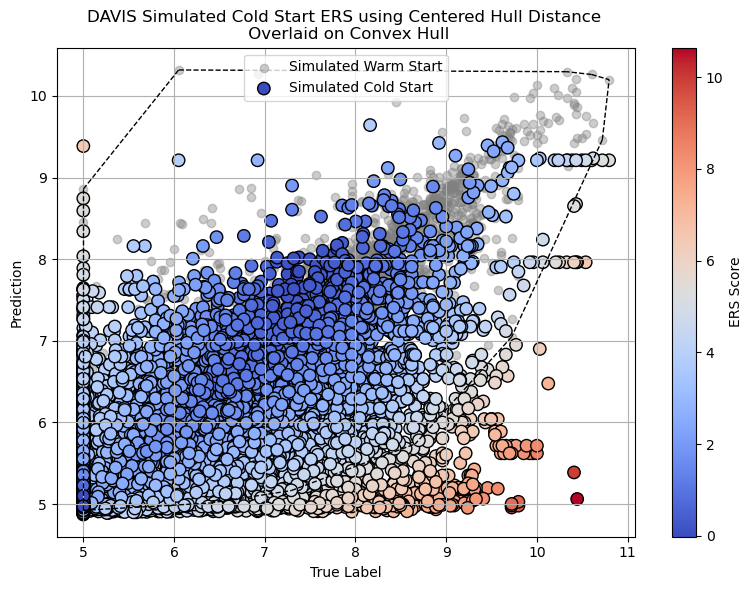

=== ERS Statistics ===

--- Overall ---
Mean ERS: 1.249
Median ERS: 0.033
Max ERS: 10.643
Std Dev: 1.595

--- Inside Hull ---
Mean ERS: 1.075
Median ERS: 0.002
Max ERS: 5.434
Std Dev: 1.381

--- Outside Hull ---
Mean ERS: 4.960
Median ERS: 4.840
Max ERS: 10.643
Std Dev: 1.309
310
310
310


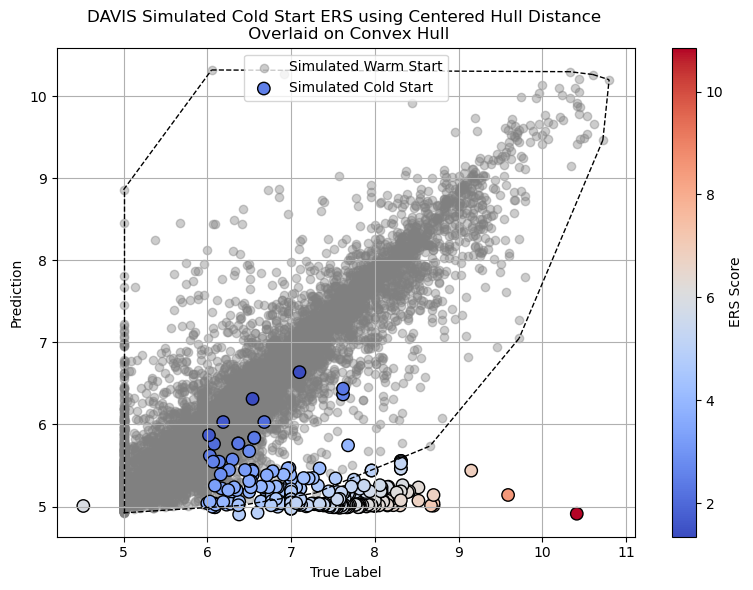

=== ERS Statistics ===

--- Overall ---
Mean ERS: 4.992
Median ERS: 5.080
Max ERS: 10.851
Std Dev: 1.095

--- Inside Hull ---
Mean ERS: 3.711
Median ERS: 3.938
Max ERS: 4.757
Std Dev: 0.868

--- Outside Hull ---
Mean ERS: 5.500
Median ERS: 5.285
Max ERS: 10.851
Std Dev: 0.682


In [8]:
# === Run ===
# ERS_vals_cspd, dists_blinded_cspd, sparsity_weights_cspd, cspds_cspd, is_inside_bl = compute_ERS_for_points(unblinded, blinded, gamma=5.0, k=20, merged =merged_df, use_cspd=True)
# plot_ERS_overlay(unblinded, blinded, ERS_vals_cspd,"CSPD")
# print_ers_statistics(ERS_vals_cspd, is_inside_bl)

ERS_vals, dists_blinded, sparsity_weights, cspds, is_inside_bl = compute_ERS_for_points(unblinded, blinded, gamma=5.0, k=20, merged =merged_df, use_cspd=False)
plot_ERS_overlay(unblinded, blinded, ERS_vals,"Centered Hull Distance")
print_ers_statistics(ERS_vals, is_inside_bl)


# === Run ===
ERS_vals_p, dists_blinded_p, sparsity_weights_p, _, is_inside_p = compute_ERS_for_points(unblinded, pharos, gamma=5.0, k=20)
plot_ERS_overlay(unblinded, pharos, ERS_vals_p, "Centered Hull Distance")
print_ers_statistics(ERS_vals_p, is_inside_p)


In [10]:
# Print ERS breakdown for max-ERS point
max_idx = np.argmax(ERS_vals)
print("ERS max value:", ERS_vals[max_idx])
print("  → Distance:", dists_blinded[max_idx])
print("  → Sparsity weight:", sparsity_weights[max_idx])


# Print ERS breakdown for max-ERS point
print("Pharos")
max_idx_p = np.argmax(ERS_vals_p)
print("ERS max value:", ERS_vals_p[max_idx_p])
print("  → Distance:", dists_blinded_p[max_idx_p])
print("  → Sparsity weight:", sparsity_weights_p[max_idx_p])

ERS max value: 10.642823158391067
  → Distance: 4.144477037399516
  → Sparsity weight: 2.5679532212027865
Pharos
ERS max value: 10.85133182993951
  → Distance: 4.213013774563562
  → Sparsity weight: 2.5756696774777645


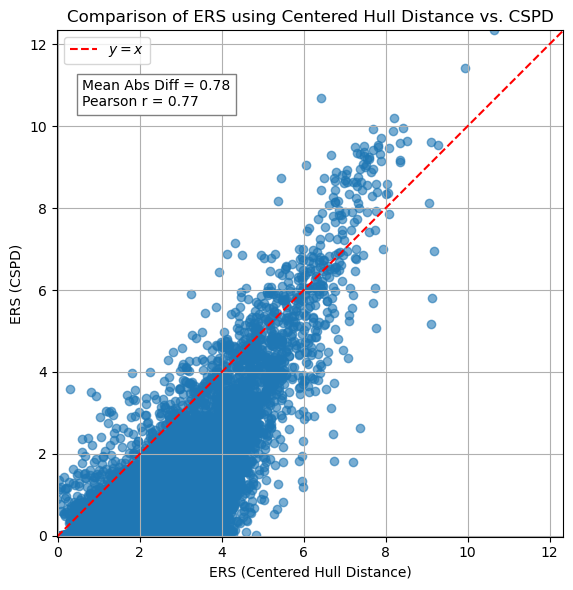

Mean absolute difference: 0.7844214599442195
Pearson correlation: 0.7690938964806089


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Compute the difference
ERS_vals_cspd = np.array(ERS_vals_cspd)
ERS_vals_hull = np.array(ERS_vals)

# Ensure same shape
assert ERS_vals_cspd.shape == ERS_vals_hull.shape

# Define common axis limits
min_val = min(ERS_vals_hull.min(), ERS_vals_cspd.min())
max_val = max(ERS_vals_hull.max(), ERS_vals_cspd.max())
# Compute stats
diff = np.abs(ERS_vals_cspd - ERS_vals_hull)
mad = diff.mean()
corr = np.corrcoef(ERS_vals_hull, ERS_vals_cspd)[0, 1]
# Scatter plot
plt.figure(figsize=(6, 6))
plt.axis("square")
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.scatter(ERS_vals_hull, ERS_vals_cspd, alpha=0.6)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='$y = x$')

# Annotate statistics
text_x = min_val + 0.05 * (max_val - min_val)
text_y = max_val - 0.15 * (max_val - min_val)
plt.text(text_x, text_y, f"Mean Abs Diff = {mad:.2f}\nPearson r = {corr:.2f}", fontsize=10, bbox=dict(facecolor='white', edgecolor='gray'))


plt.xlabel("ERS (Centered Hull Distance)")
plt.ylabel("ERS (CSPD)")
plt.title("Comparison of ERS using Centered Hull Distance vs. CSPD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print mean absolute difference and correlation
diff = np.abs(ERS_vals_cspd - ERS_vals_hull)
print("Mean absolute difference:", diff.mean())
print("Pearson correlation:", np.corrcoef(ERS_vals_hull, ERS_vals_cspd)[0, 1])



Inside Hull:
  Mean absolute difference: 0.7293456617220002
  Pearson correlation: 0.7261586123445317


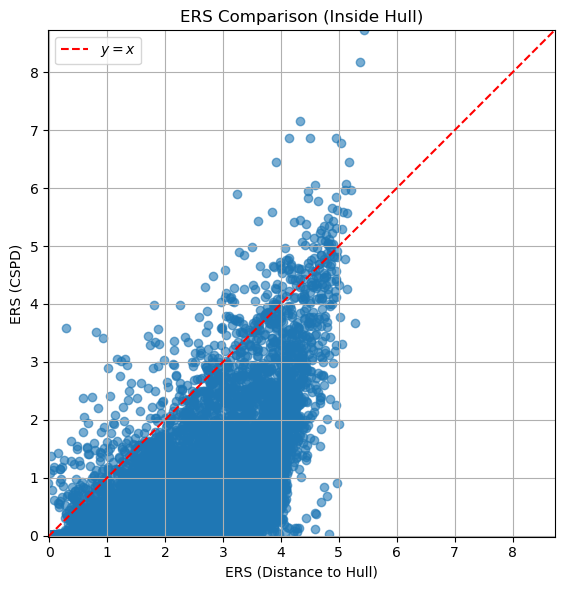


Outside Hull:
  Mean absolute difference: 1.963123944524855
  Pearson correlation: 0.9017029680888075


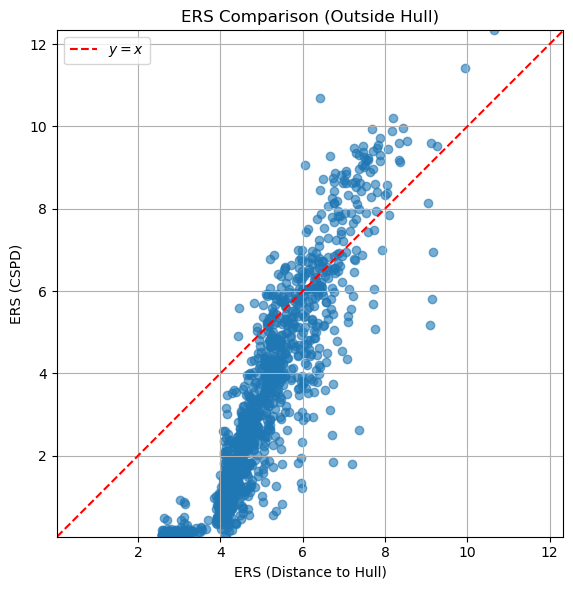

In [12]:
# Convert to arrays if needed
ERS_vals_cspd = np.array(ERS_vals_cspd)
ERS_vals_hull = np.array(ERS_vals)
is_inside_bl = np.array(is_inside_bl)  # True = inside hull

# Masked splits
inside_mask = is_inside_bl
outside_mask = ~is_inside_bl

# Compute metrics
for label, mask in [("Inside Hull", inside_mask), ("Outside Hull", outside_mask)]:
    hull_vals = ERS_vals_hull[mask]
    cspd_vals = ERS_vals_cspd[mask]
    diff = np.abs(hull_vals - cspd_vals)
    corr = np.corrcoef(hull_vals, cspd_vals)[0, 1]
    print(f"\n{label}:")
    print("  Mean absolute difference:", diff.mean())
    print("  Pearson correlation:", corr)

    # Scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(hull_vals, cspd_vals, alpha=0.6)
    
    # Get common axis range
    min_val = min(hull_vals.min(), cspd_vals.min())
    max_val = max(hull_vals.max(), cspd_vals.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='$y = x$')
    
    # Set same axis scale
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.gca().set_aspect('equal', adjustable='box')  # Force square aspect ratio
    
    plt.xlabel("ERS (Distance to Hull)")
    plt.ylabel("ERS (CSPD)")
    plt.title(f"ERS Comparison ({label})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


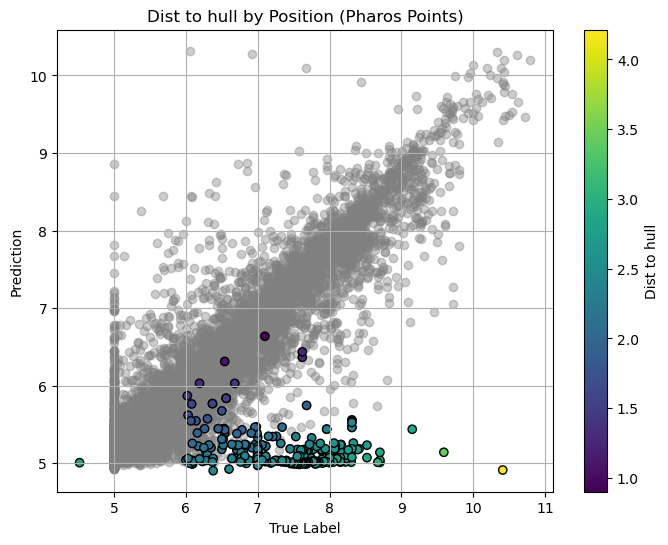

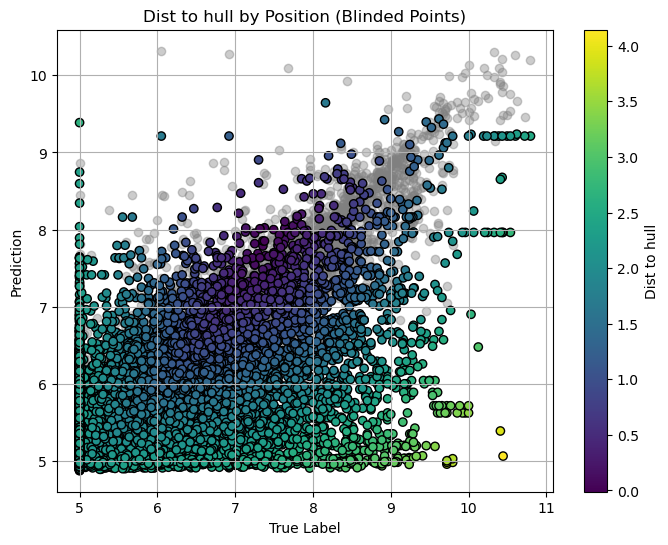

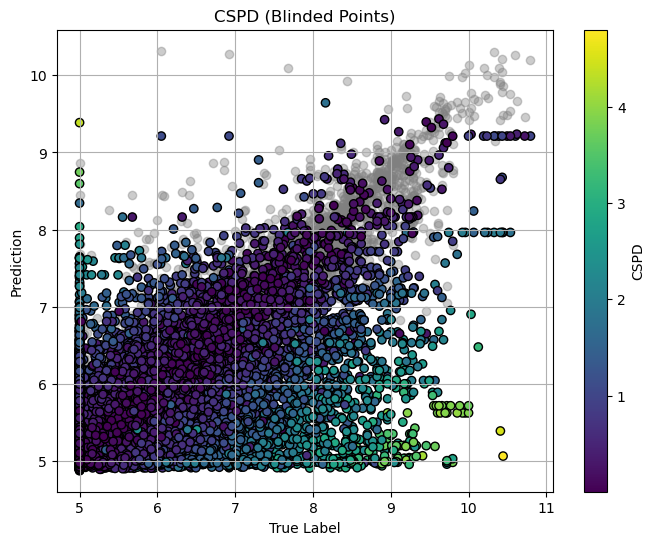

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(unblinded[:, 0], unblinded[:, 1], color='gray', alpha=0.4, label='Unblinded')
sc = plt.scatter(pharos[:, 0], pharos[:, 1], c=dists_blinded_p, cmap='viridis', edgecolor='black')
plt.colorbar(sc, label="Dist to hull")
plt.title("Dist to hull by Position (Pharos Points)")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(unblinded[:, 0], unblinded[:, 1], color='gray', alpha=0.4, label='Unblinded')
sc = plt.scatter(blinded[:, 0], blinded[:, 1], c=dists_blinded, cmap='viridis', edgecolor='black')
plt.colorbar(sc, label="Dist to hull")
plt.title("Dist to hull by Position (Blinded Points)")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(unblinded[:, 0], unblinded[:, 1], color='gray', alpha=0.4, label='Unblinded')
sc = plt.scatter(blinded[:, 0], blinded[:, 1], c=cspds_cspd, cmap='viridis', edgecolor='black')
plt.colorbar(sc, label="CSPD")
plt.title("CSPD (Blinded Points)")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.grid(True)
plt.show()

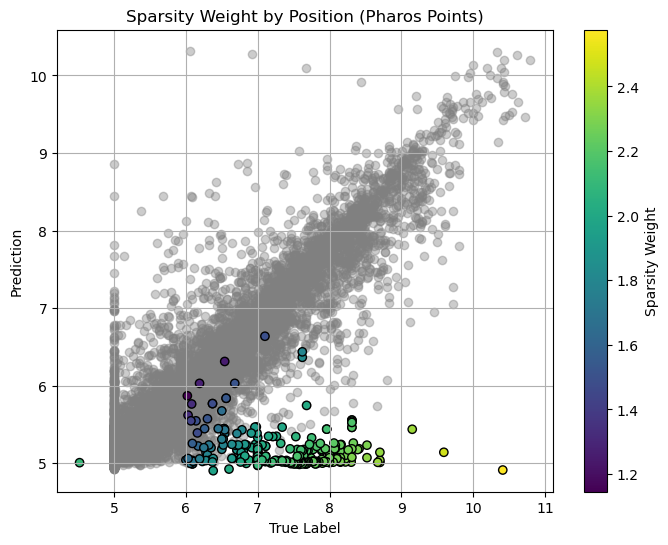

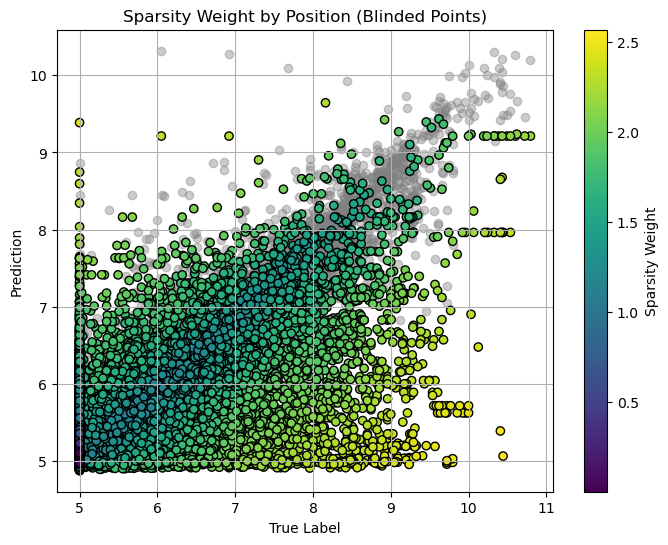

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(unblinded[:, 0], unblinded[:, 1], color='gray', alpha=0.4, label='Unblinded')
sc = plt.scatter(pharos[:, 0], pharos[:, 1], c=sparsity_weights_p, cmap='viridis', edgecolor='black')
plt.colorbar(sc, label="Sparsity Weight")
plt.title("Sparsity Weight by Position (Pharos Points)")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(unblinded[:, 0], unblinded[:, 1], color='gray', alpha=0.4, label='Unblinded')
sc = plt.scatter(blinded[:, 0], blinded[:, 1], c=sparsity_weights, cmap='viridis', edgecolor='black')
plt.colorbar(sc, label="Sparsity Weight")
plt.title("Sparsity Weight by Position (Blinded Points)")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.grid(True)
plt.show()

# SHOW THAT CSPD CORRELATES WITH signed DIST FROM CONVEX HULL 
and thus using dist from hull as proxy for cspd in pharos case is logical

In [15]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy.stats import pearsonr

# # Convert to arrays

# dists_blinded_cspd = np.array(dists_blinded_cspd)
# cspds_cspd = np.array(cspds_cspd)

# inside_mask = is_inside_bl
# outside_mask = ~is_inside_bl


# sns.set(style="whitegrid")
# fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# # === Inside points ===
# sns.regplot(
#     x=dists_blinded_cspd[inside_mask],
#     y=cspds_cspd[inside_mask],
#     scatter_kws={'alpha': 0.6},
#     ax=axes[0]
# )
# r_in, p_in = pearsonr(dists_blinded_cspd[inside_mask], cspds_cspd[inside_mask])
# axes[0].set_title(f'Inside Hull\nPearson r={r_in:.2f}, p={p_in:.2g}')
# axes[0].set_xlabel('Centered Hull Distance')
# axes[0].set_ylabel('CSPD')

# # === Outside points ===
# sns.regplot(
#     x=dists_blinded_cspd[outside_mask],
#     y=cspds_cspd[outside_mask],
#     scatter_kws={'alpha': 0.6},
#     ax=axes[1]
# )
# r_out, p_out = pearsonr(dists_blinded_cspd[outside_mask], cspds_cspd[outside_mask])
# axes[1].set_title(f'Outside Hull\nPearson r={r_out:.2f}, p={p_out:.2g}')
# axes[1].set_xlabel('Centered Hull Distance')
# axes[1].set_ylabel('')  # shared y-axis
 
# plt.suptitle('CSPD vs. Centered Hull Distance (Split by Inside/Outside)', fontsize=14)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()

In [16]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# # Assume:
# # - ERS_vals = signed distance to hull
# # - sparsity_weights = local density scores
# # - cspds = CSPD = abs(ERS_vals) * sparsity_weights
# # - predicted_affinities = model predictions for each point (same order)

# # Sanity check
# # Compute CSPD
# cspds = np.abs(ERS_vals) * sparsity_weights

# # Bin by integer-valued predicted affinity
# aff_bin = np.floor(blinded_df["Blinded_Prediction"]).astype(int)

# # Compute difference between CSPD and |ERS|
# diffs = cspds - np.abs(ERS_vals)

# # Create DataFrame
# df = pd.DataFrame({
#     "Affinity_Bin": aff_bin,
#     "ERS": ERS_vals,
#     "CSPD": cspds,
#     "Abs_Diff": diffs
# })

# # Group and plot average difference per bin
# grouped = df.groupby("Affinity_Bin")["Abs_Diff"].agg(["mean", "count", "std"])
# grouped = grouped[grouped["count"] >= 5]  # drop small bins for stability

# plt.figure(figsize=(8, 5))
# plt.errorbar(
#     grouped.index,
#     grouped["mean"],
#     yerr=grouped["std"] / np.sqrt(grouped["count"]),  # SEM
#     fmt='o-', capsize=4
# )
# plt.axhline(0, linestyle='--', color='gray')
# plt.xlabel("Predicted Affinity Bin (floor)")
# plt.ylabel("Avg. CSPD − |ERS|")
# plt.title("Mean CSPD − |ERS| per Predicted Affinity Bin")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [17]:
# import pandas as pd
# bin_df = pd.DataFrame({
#     "distance": dists_blinded[inside_mask],
#     "cspd": cspds[inside_mask]
# })
# bin_df["bin"] = pd.qcut(bin_df["distance"], q=20, duplicates="drop")
# bin_means = bin_df.groupby("bin").mean()

# plt.figure(figsize=(6,4))
# sns.lineplot(data=bin_means, x="distance", y="cspd", marker="o")
# plt.title("Binned Mean CSPD vs Distance (Inside Hull)")
# plt.xlabel("Signed Distance to Hull")
# plt.ylabel("CSPD")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


# CSVS
turn ERS and chr into csvs

(#inside pts/#total pts)(avg ERS inside) + (#outside pts/#total pts)(avg ERS outside) but would weight the inside points heavily

so maybe CSVS_model = CHR * mean_ERS_outside
CHR is the fraction of outside points

In [18]:
import numpy as np

def compute_model_level_csvs(ERS_vals, is_inside):
    ERS_vals = np.array(ERS_vals)
    is_inside = np.array(is_inside)

    # Boolean masks
    inside_mask = is_inside
    outside_mask = ~is_inside

    # Count totals
    num_total = len(ERS_vals)
    num_inside = inside_mask.sum()
    num_outside = outside_mask.sum()

    # Compute CHR
    CHR = num_outside / num_total if num_total > 0 else 0.0

    # Means (safe fallback to NaN if no points)
    mean_ERS_inside = ERS_vals[inside_mask].mean() if num_inside > 0 else np.nan
    mean_ERS_outside = ERS_vals[outside_mask].mean() if num_outside > 0 else np.nan

    # === Option 1: Weighted Average (original proposal) ===
    CSVS_weighted = (
        (num_inside / num_total) * mean_ERS_inside +
        (num_outside / num_total) * mean_ERS_outside
        if num_total > 0 else np.nan
    )

    # === Option 2: CHR-weighted outside ERS (recommended) ===
    CSVS_chr_scaled = CHR * mean_ERS_outside if mean_ERS_outside is not np.nan else np.nan

    return {
        "CHR": CHR,
        "Mean_ERS_inside": mean_ERS_inside,
        "Mean_ERS_outside": mean_ERS_outside,
        "CSVS_weighted": CSVS_weighted,
        "CSVS_chr_scaled": CSVS_chr_scaled
    }

In [19]:
print("CSVS DAVIS UNBLINDED")
results = compute_model_level_csvs(ERS_vals, is_inside_bl)
print("CHR:", results["CHR"])
print("Mean ERS (inside):", results["Mean_ERS_inside"])
print("Mean ERS (outside):", results["Mean_ERS_outside"])
print("CSVS (weighted):", results["CSVS_weighted"])
print("CSVS (CHR × mean outside ERS):", results["CSVS_chr_scaled"])

print("CSVS PHAROS")
results_p = compute_model_level_csvs(ERS_vals_p, is_inside_p)
print("CHR:", results_p["CHR"])
print("Mean ERS (inside):", results_p["Mean_ERS_inside"])
print("Mean ERS (outside):", results_p["Mean_ERS_outside"])
print("CSVS (weighted):", results_p["CSVS_weighted"])
print("CSVS (CHR × mean outside ERS):", results_p["CSVS_chr_scaled"])

CSVS DAVIS UNBLINDED
CHR: 0.044639947865754315
Mean ERS (inside): 1.0751455427994836
Mean ERS (outside): 4.960095147650435
CSVS (weighted): 1.2485694906211129
CSVS (CHR × mean outside ERS): 0.22141838880029635
CSVS PHAROS
CHR: 0.7161290322580646
Mean ERS (inside): 3.7107888327170855
Mean ERS (outside): 5.499615711906273
CSVS (weighted): 4.991819694588052
CSVS (CHR × mean outside ERS): 3.938434477558686


# Confidence

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import wasserstein_distance

def compute_csvs_generalizability_confidence_v2(
    user_df, blinded_df, unblinded_df,
    user_drug_embeddings, user_protein_embeddings,
    blinded_drug_embeddings, blinded_protein_embeddings,
    gamma_emb=0.4, gamma_shift=0.4, gamma_geom=0.2,
    affinity_col="Predicted_Value", max_wasserstein=5.0
):
    """
    Improved version: computes CSVS generalizability confidence for a user's cold-start dataset.

    Parameters:
    - user_df: user's dataset with Drug_ID, Protein_ID, Predicted_Value
    - blinded_df: benchmark blinded set used in CSVS estimation
    - unblinded_df: training set (used to construct convex hull)
    - *_embeddings: dicts with separated embeddings for user and blinded data
    - gamma_*: weights for component contributions
    - max_wasserstein: normalization bound for prediction shift

    Returns:
    - dict with overall confidence and component-level scores
    """

    # ---- 1. Embedding similarity ----
    drug_sims, prot_sims = [], []
    for _, row in user_df.iterrows():
        did, pid = row["Drug_ID"], row["Protein_ID"]

        if did in user_drug_embeddings and pid in user_protein_embeddings:
            d_emb = user_drug_embeddings[did].reshape(1, -1)
            p_emb = user_protein_embeddings[pid].reshape(1, -1)

            blinded_d_embs = np.stack([
                blinded_drug_embeddings[d] for d in blinded_df["Drug_ID"]
                if d in blinded_drug_embeddings
            ])
            blinded_p_embs = np.stack([
                blinded_protein_embeddings[p] for p in blinded_df["Protein_ID"]
                if p in blinded_protein_embeddings
            ])

            if len(blinded_d_embs) > 0:
                d_sim = cosine_similarity(d_emb, blinded_d_embs).mean()
                drug_sims.append(d_sim)
            if len(blinded_p_embs) > 0:
                p_sim = cosine_similarity(p_emb, blinded_p_embs).mean()
                prot_sims.append(p_sim)

    emb_score = np.mean(drug_sims + prot_sims) if (drug_sims and prot_sims) else 0.0

    # ---- 2. Prediction distribution shift ----
    user_preds = user_df[affinity_col].values
    blinded_preds = blinded_df[affinity_col].values
    shift_score = wasserstein_distance(user_preds, blinded_preds) / max_wasserstein
    shift_score = 1.0 - min(shift_score, 1.0)

    # ---- 3. Geometry: fraction inside convex hull ----
    try:
        hull_points = unblinded_df[["True_Label", "Predicted_Value"]].dropna().values
        if len(hull_points) >= 3:
            hull = ConvexHull(hull_points)
            polygon = Polygon(hull_points[hull.vertices])
            user_points = user_df[[affinity_col]].copy()
            user_points["True_Label"] = unblinded_df["True_Label"].mean()
            user_points = user_points[["True_Label", affinity_col]].values

            inside_mask = np.array([polygon.covers(Point(p)) for p in user_points])
            frac_inside = inside_mask.mean()
        else:
            frac_inside = 0.0
    except Exception:
        frac_inside = 0.0

    geom_score = frac_inside

    # ---- Final confidence score ----
    confidence = gamma_emb * emb_score + gamma_shift * shift_score + gamma_geom * geom_score
    result = {
        "confidence": round(confidence, 4),
        "embedding_similarity": round(emb_score, 4),
        "prediction_distribution_alignment": round(shift_score, 4),
        "geometry_overlap": round(geom_score, 4)
    }
    return result

In [21]:
pharos_df = pharos_df.rename(columns={"drug_id": "Drug_ID"})
pharos_df = pharos_df.rename(columns={"prot_id": "Protein_ID"})
pharos_df["Drug_ID"] = pharos_df["Drug_ID"].astype(str)
pharos_df["Protein_ID"] = pharos_df["Protein_ID"].astype(str)
blinded_df["Drug_ID"] = blinded_df["Drug_ID"].astype(str)
blinded_df["Protein_ID"] = blinded_df["Protein_ID"].astype(str)
unblinded_df["Drug_ID"] = unblinded_df["Drug_ID"].astype(str)
unblinded_df["Protein_ID"] = unblinded_df["Protein_ID"].astype(str)
print(blinded_df.columns)
print(unblinded_df.columns)
print(pharos_df.columns)
blinded_df = blinded_df.rename(columns={"Blinded_Prediction": "Predicted_Value"})
unblinded_df = unblinded_df.rename(columns={"Unblinded_Prediction": "Predicted_Value"})
pharos_df = pharos_df.rename(columns={"Blinded_Prediction": "Predicted_Value"})

result = compute_csvs_generalizability_confidence_v2(
    user_df=pharos_df,
    blinded_df=blinded_df,
    unblinded_df=unblinded_df,
    user_drug_embeddings=pharos_drug_embeddings,
    user_protein_embeddings=pharos_protein_embeddings,
    blinded_drug_embeddings=davis_drug_embeddings,
    blinded_protein_embeddings=davis_protein_embeddings
)

print(result)

Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Blinded_Prediction', 'Fold'], dtype='object')
Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Unblinded_Prediction'], dtype='object')
Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Blinded_Prediction'], dtype='object')
{'confidence': 0.8688, 'embedding_similarity': 0.7171, 'prediction_distribution_alignment': 0.9597, 'geometry_overlap': 0.9903}


see if theres a way to validate... maybe split up the pharos set? and compute csvs for each and then see how confidence ranks them? naa

# INFERENCE
Need to infer csvs for each point in pharos using what i have for davis. (then validate by checking against csvs as i have defined it for pharos (which uses true affinity))

In [22]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def prepare_davis_triplet_df(davis_df, protein_embeddings, drug_embeddings):
    triplets = []

    for _, row in davis_df.iterrows():
        pid = row["Protein_ID"]
        did = row["Drug_ID"]
        pred_aff = row["Predicted_Value"]
        if pid in protein_embeddings and did in drug_embeddings:
            triplets.append({
                "Protein_ID": pid,
                "Drug_ID": did,
                "Predicted_Value": pred_aff,
                "ERS": row["ERS"],
                "prot_emb": protein_embeddings[pid],
                "drug_emb": drug_embeddings[did]
            })

    triplet_df = pd.DataFrame(triplets)
    return triplet_df

def build_similarity_matrices(pharos_df, davis_triplet_df, protein_embeddings, drug_embeddings):
    pharos_prot_ids = pharos_df["Protein_ID"].unique()
    davis_prot_ids = davis_triplet_df["Protein_ID"].unique()
    pharos_drug_ids = pharos_df["Drug_ID"].unique()
    davis_drug_ids = davis_triplet_df["Drug_ID"].unique()

    # Protein similarity matrix
    prot_matrix = cosine_similarity(
        [protein_embeddings[pid] for pid in pharos_prot_ids],
        [protein_embeddings[dpid] for dpid in davis_prot_ids]
    )

    # Drug similarity matrix
    drug_matrix = cosine_similarity(
        [drug_embeddings[did] for did in pharos_drug_ids],
        [drug_embeddings[ddid] for ddid in davis_drug_ids]
    )

    return (
        pd.DataFrame(prot_matrix, index=pharos_prot_ids, columns=davis_prot_ids),
        pd.DataFrame(drug_matrix, index=pharos_drug_ids, columns=davis_drug_ids)
    )

def build_neighborhood_df_for_pharos_point_fast(
    pharos_point,
    davis_triplet_df,
    protein_sim_matrix,
    drug_sim_matrix,
    top_k=5,
    weights=(0.4, 0.4, 0.2)  # (protein, drug, affinity)
):
    """
    Fast neighborhood builder using precomputed similarity matrices.
    """
    pid, did, pred_aff = pharos_point["Protein_ID"], pharos_point["Drug_ID"], pharos_point["Predicted_Value"]

    if pid not in protein_sim_matrix.index or did not in drug_sim_matrix.index:
        return None

    # Extract similarities from precomputed matrices
    prot_sims = protein_sim_matrix.loc[pid].reindex(davis_triplet_df["Protein_ID"].values).values
    drug_sims = drug_sim_matrix.loc[did].reindex(davis_triplet_df["Drug_ID"].values).values
    #aff_sims = -np.abs(davis_triplet_df["Predicted_Value"].values - pred_aff) 
    aff_diff = np.abs(davis_triplet_df["Predicted_Value"] - pred_aff)

    prot_sims = (prot_sims - prot_sims.min()) / (prot_sims.max() - prot_sims.min())
    drug_sims = (drug_sims - drug_sims.min()) / (drug_sims.max() - drug_sims.min())
    aff_sims = 1 - (aff_diff / aff_diff.max())

    #weights each portion of the similarity score
    total_sims = (
        weights[0] * prot_sims +
        weights[1] * drug_sims +
        weights[2] * aff_sims
    )

    top_k_idx = np.argsort(total_sims)[-top_k:]

    neighborhood_df = davis_triplet_df.iloc[top_k_idx].copy()
    neighborhood_df["similarity"] = total_sims[top_k_idx]

    return neighborhood_df.reset_index(drop=True)


# def assign_ERS_by_similarity(neighborhood_df):
#     """
#     Weighted average ERS of neighbors, weighted by similarity.
#     """
#     if neighborhood_df is None or neighborhood_df.empty:
#         return np.nan, np.nan

#     dvs = neighborhood_df["ERS"].values
#     print("neighborhood dvs:", dvs)
#     sims = neighborhood_df["similarity"].values
#     print("neighborhood sims:", sims)

#     inferred_ERS = np.average(dvs, weights=sims + 1e-8)
#     confidence = sims.mean()  # or max(sims) for a conservative metric

#     return inferred_ERS, confidence

def assign_ERS_by_similarity(neighborhood_df, alpha=1.0):
    """
    Weighted average ERS of neighbors, weighted by similarity, 
    plus a penalty for low similarity to the Davis set.
    """
    if neighborhood_df is None or neighborhood_df.empty:
        return np.nan, np.nan

    dvs = neighborhood_df["ERS"].values
    sims = neighborhood_df["similarity"].values

    # Weighted average as before
    weighted_ERS = np.average(dvs, weights=sims + 1e-8)
    
    
    #RELOOOK HEREEE
    
    
    
    # Dissimilarity penalty: higher if max similarity is low
    penalty = 1 - np.max(sims)  # You can also try 1 - np.mean(sims)
    
    # Final inferred ERS: add penalty term
    inferred_ERS = weighted_ERS + alpha * penalty

    # Confidence can still be the mean or max similarity
    confidence = sims.mean()  # or max(sims) for a conservative metric

    return inferred_ERS, confidence


In [23]:
# === Ensure string types for ID columns ===
pharos_df["Protein_ID"] = pharos_df["Protein_ID"].astype(str)
pharos_df["Drug_ID"] = pharos_df["Drug_ID"].astype(str)
blinded_df["Protein_ID"] = blinded_df["Protein_ID"].astype(str)
blinded_df["Drug_ID"] = blinded_df["Drug_ID"].astype(str)

blinded_df["DTH"] = dists_blinded
blinded_df["ERS"] = ERS_vals
blinded_df["CSPD"] = cspds
blinded_df["Sparsity_Weight"] = sparsity_weights
print("ERS count:", len(ERS_vals))

# === Assign ERS values to blinded_df ===
outside_mask = blinded_df["DTH"] > 0  # or use CSPD > threshold
davis_outside_df = blinded_df[outside_mask]

# === Prepare DAVIS triplet dataframe (with embeddings) ===
davis_triplet_df = prepare_davis_triplet_df(davis_outside_df, protein_embeddings, drug_embeddings)

# === Precompute similarity matrices ===
protein_sim_matrix, drug_sim_matrix = build_similarity_matrices(
    pharos_df, davis_triplet_df, protein_embeddings, drug_embeddings
)

# === Build neighborhoods using fast method ===
neighborhoods = {}

for _, pharos_point in pharos_df.iterrows():
    key = (
        pharos_point["Drug_ID"],
        pharos_point["Protein_ID"],
        pharos_point["Predicted_Value"]
    )
    
    n_df = build_neighborhood_df_for_pharos_point_fast(
        pharos_point=pharos_point,
        davis_triplet_df=davis_triplet_df,
        protein_sim_matrix=protein_sim_matrix,
        drug_sim_matrix=drug_sim_matrix,
        top_k=5,
        weights=(0.1, 0.1, 0.8)
    )
    
    if n_df is not None:
        neighborhoods[key] = n_df

#Infer DVs
inferred_ERSs = []
ERS_confidences = []

for _, row in pharos_df.iterrows():
    key = (
        row["Drug_ID"],
        row["Protein_ID"],
        row["Predicted_Value"]
    )
    n_df_i = neighborhoods.get(key, None)
    ERS, conf = assign_ERS_by_similarity(n_df_i)
    inferred_ERSs.append(ERS)
    ERS_confidences.append(conf)

pharos_df["Inferred_ERS"] = inferred_ERSs
pharos_df["ERS_Confidence"] = ERS_confidences

print(inferred_ERSs)
pharos_df["Inferred_CSVS_alt"] = pharos_df["Inferred_ERS"] * pharos_df["ERS_Confidence"]
# Add true ERS
pharos_df["ERS"] = ERS_vals_p


ERS count: 27621
[1.8444211690832792, 1.9888628213825654, 1.422416052865467, 0.5827158154859065, 0.9993137207330038, 0.9720916952156419, 1.8081305782418764, 0.8119270988281277, 0.916664340879588, 0.014623324061707403, 0.6084535601352209, 2.349244105565553, 0.5973938698543915, 1.6416520082476609, 1.5293168916957638, 3.1604265695719747, 0.007101080166882483, 1.1874903952677802, 0.4182375339412507, 1.9181126845537158, 1.9133728062093975, 1.2663956139940833, 0.5257827940587129, 1.2648112302332595, 1.3440306797298072, 0.6358993354473458, 0.47749322303852776, 2.389134149766859, 0.5024373138636273, 0.36031703125899883, 2.203761472962387, 0.9048979665845489, 0.9954990221312137, 0.8770403124809099, 2.415776089918946, 1.0472363822538955, 1.6238440932593128, 0.7065423657157462, 1.435854028785056, 2.590039988764587, 0.9245574041073451, 0.9718019558229467, 0.7714408114119768, 1.0073930864443883, 2.349244105565553, 0.00898618451292376, 1.0282392615129683, 1.515766997354067, 0.5448103740871151, 1.525

Spearman: SignificanceResult(statistic=0.020944177832654585, pvalue=0.713387127031757)
Pearson: PearsonRResult(statistic=-0.058552814983252835, pvalue=0.30411642088177404)


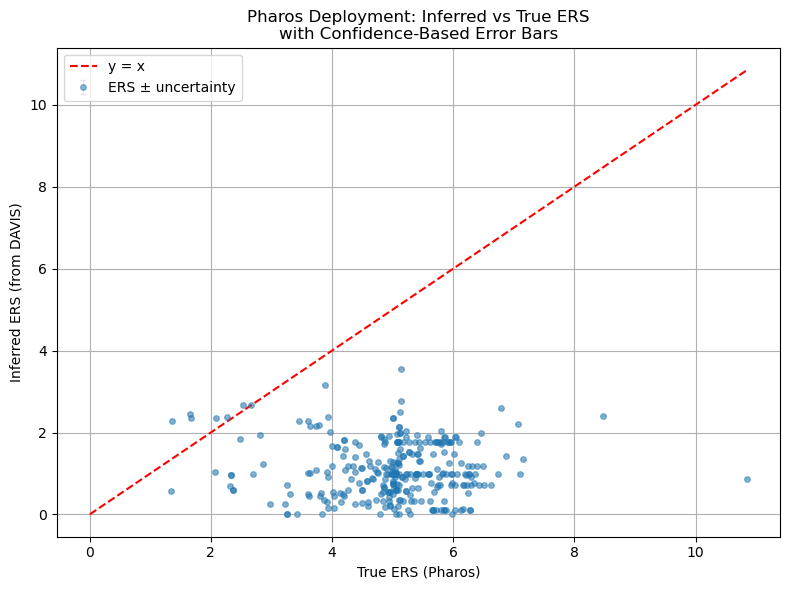

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

# Correlation
print("Spearman:", spearmanr(pharos_df["ERS"], pharos_df["Inferred_ERS"]))
print("Pearson:", pearsonr(pharos_df["ERS"], pharos_df["Inferred_ERS"]))

# === Scatter Plot with Confidence Bars ===
plt.figure(figsize=(8, 6))

# Sort for layering: larger errors behind smaller ones
sorted_df = pharos_df.sort_values("ERS_Confidence", ascending=False)

# Plot points with vertical error bars
plt.errorbar(
    x=sorted_df["ERS"],
    y=sorted_df["Inferred_ERS"],
    yerr=np.abs(1 - sorted_df["ERS_Confidence"]),  # inverse confidence as error bar
    fmt='o',
    ecolor='lightgray',
    elinewidth=1,
    alpha=0.5,
    capsize=2,
    markersize=4,
    label="ERS ± uncertainty"
)

# Diagonal identity line
min_val = min(pharos_df["ERS"].min(), pharos_df["Inferred_ERS"].min())
max_val = max(pharos_df["ERS"].max(), pharos_df["Inferred_ERS"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

# Labels and formatting
plt.xlabel("True ERS (Pharos)")
plt.ylabel("Inferred ERS (from DAVIS)")
plt.title("Pharos Deployment: Inferred vs True ERS\nwith Confidence-Based Error Bars")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


count    246.000000
mean       1.424587
std        0.713537
min        0.000000
25%        0.948510
50%        1.395087
75%        1.785927
max        4.369472
dtype: float64


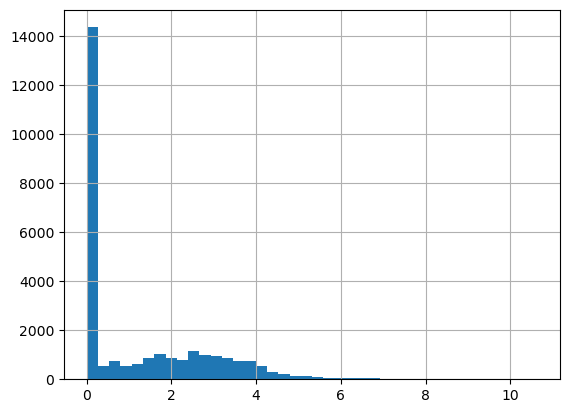

In [25]:
davis_triplet_df["ERS"].hist(bins=40)

# For each neighborhood, compute std of ERS
neighborhood_ERS_stds = [n["ERS"].std() for n in neighborhoods.values()]
print(pd.Series(neighborhood_ERS_stds).describe())

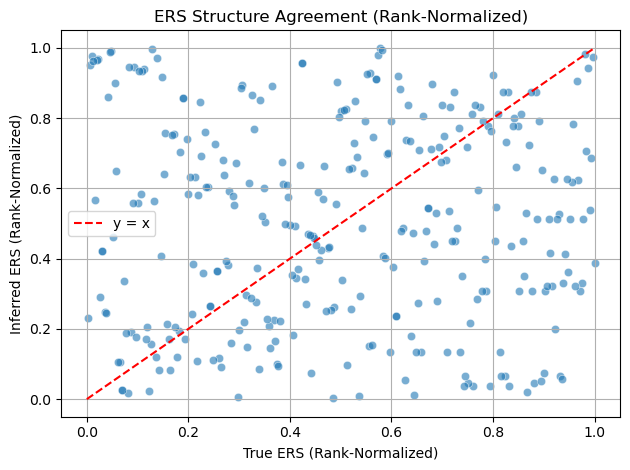

In [26]:
from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt

pharos_df["ERS_rank"] = rankdata(pharos_df["ERS"]) / len(pharos_df)
pharos_df["Inferred_ERS_rank"] = rankdata(pharos_df["Inferred_ERS"]) / len(pharos_df)

sns.scatterplot(data=pharos_df, x="ERS_rank", y="Inferred_ERS_rank", alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--', label='y = x')
plt.xlabel("True ERS (Rank-Normalized)")
plt.ylabel("Inferred ERS (Rank-Normalized)")
plt.title("ERS Structure Agreement (Rank-Normalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

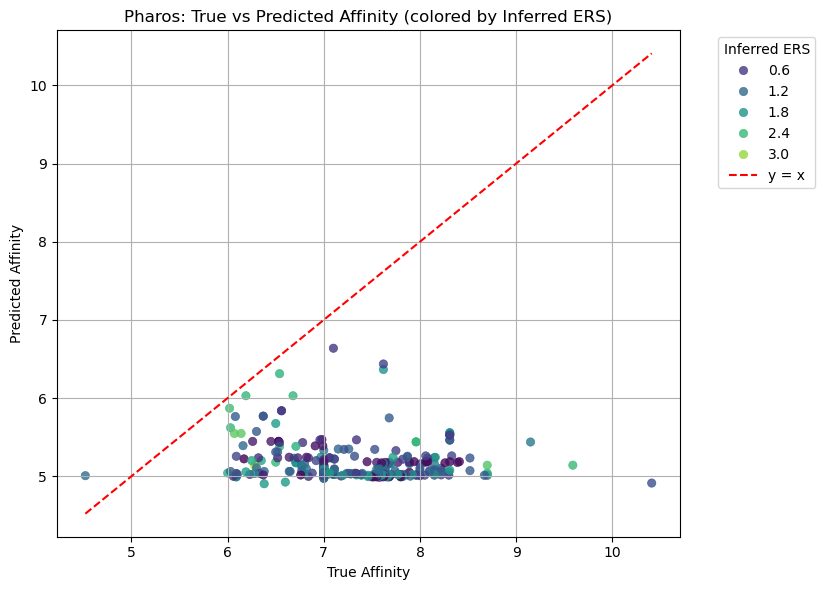

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 6))
scatter = sns.scatterplot(
    data=pharos_df,
    x="True_Label",
    y="Predicted_Value",
    hue="Inferred_ERS",
    palette="viridis",
    alpha=0.8,
    edgecolor=None
)

# Diagonal reference line
plt.plot([pharos_df["True_Label"].min(), pharos_df["True_Label"].max()],
         [pharos_df["True_Label"].min(), pharos_df["True_Label"].max()],
         'r--', label="y = x")

plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("Pharos: True vs Predicted Affinity (colored by Inferred ERS)")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Inferred ERS", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

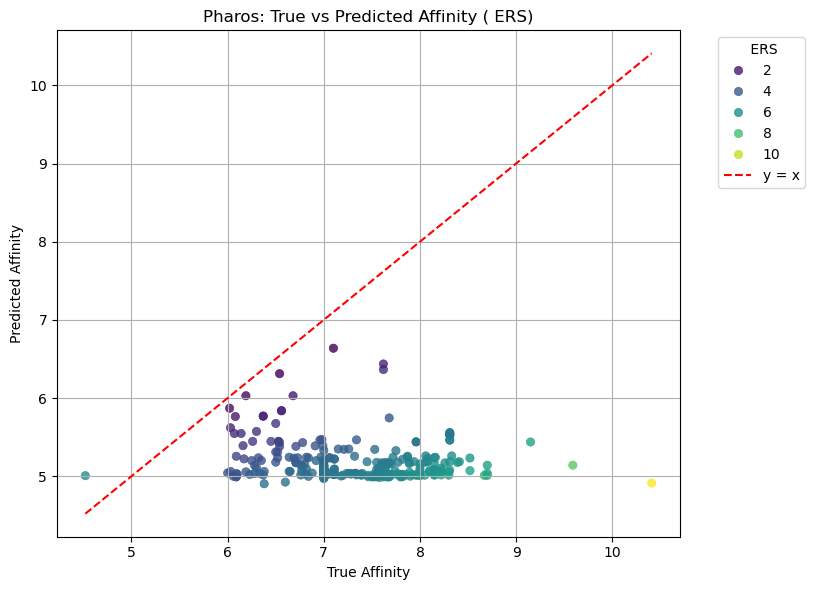

In [28]:
import seaborn as sns

plt.figure(figsize=(7, 6))
scatter = sns.scatterplot(
    data=pharos_df,
    x="True_Label",
    y="Predicted_Value",
    hue="ERS",
    palette="viridis",
    alpha=0.8,
    edgecolor=None
)

# Diagonal reference line
plt.plot([pharos_df["True_Label"].min(), pharos_df["True_Label"].max()],
         [pharos_df["True_Label"].min(), pharos_df["True_Label"].max()],
         'r--', label="y = x")

plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("Pharos: True vs Predicted Affinity ( ERS)")
plt.grid(True)
plt.tight_layout()
plt.legend(title=" ERS", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# nn Model

In [29]:
import torch
import torch.nn as nn

class DVWithInteraction(nn.Module):
    def __init__(self, drug_dim, prot_dim, embed_dim=128, use_aux_dim=2, hidden_dim=512, dropout=0.3):
        super().__init__()
        self.use_aux_dim = use_aux_dim
        self.embed_dim = embed_dim

        # Projection to common space
        self.proj_drug = nn.Linear(drug_dim, embed_dim)
        self.proj_prot = nn.Linear(prot_dim, embed_dim)

        # Final input dim = d_proj + p_proj + interaction1 + interaction2 + affinity + aux
        input_dim = embed_dim * 4 + 1 + use_aux_dim

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, drug_emb, prot_emb, affinity, side_info=None):
        if side_info is None:
            side_info = torch.zeros(drug_emb.size(0), self.use_aux_dim, device=drug_emb.device)

        # Project to shared embedding space
        d_proj = self.proj_drug(drug_emb)
        p_proj = self.proj_prot(prot_emb)

        # Compute interactions
        abs_diff = torch.abs(d_proj - p_proj)
        prod = d_proj * p_proj

        # Combine all features
        x = torch.cat([d_proj, p_proj, abs_diff, prod, affinity, side_info], dim=1)
        return self.net(x)


In [36]:
def build_dataset(df, drug_embeddings, protein_embeddings, side_feature_cols=None):
    X_drug, X_prot, X_aff, y_ERS = [], [], [], []
    X_side = []

    for _, row in df.iterrows():
        did, pid = row["Drug_ID"], row["Protein_ID"]
        if did in drug_embeddings and pid in protein_embeddings:
            X_drug.append(drug_embeddings[did])
            X_prot.append(protein_embeddings[pid])
            X_aff.append([row["Predicted_Value"]])
            y_ERS.append(row["ERS"])

            if side_feature_cols:
                X_side.append([row[col] for col in side_feature_cols])

    return (
        torch.tensor(np.array(X_drug), dtype=torch.float32),
        torch.tensor(np.array(X_prot), dtype=torch.float32),
        torch.tensor(np.array(X_aff), dtype=torch.float32),
        torch.tensor(np.array(y_ERS), dtype=torch.float32).unsqueeze(1),
        torch.tensor(np.array(X_side), dtype=torch.float32) if side_feature_cols else None
    )

In [37]:
print(davis_outside_df.columns)
print(unblinded_df.columns)
unblinded_df_2 = unblinded_df.rename(columns={"Predicted_Value": "Unblinded_Prediction"})
print(unblinded_df.columns)
davis_outside_df_2 = pd.merge(
    unblinded_df_2[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    davis_outside_df[["Drug_ID", "Protein_ID", "True_Label", "Predicted_Value","Fold","DTH","ERS","CSPD","Sparsity_Weight"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)
print(davis_outside_df_2.columns)

Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Predicted_Value', 'Fold', 'DTH',
       'ERS', 'CSPD', 'Sparsity_Weight'],
      dtype='object')
Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Predicted_Value'], dtype='object')
Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Predicted_Value'], dtype='object')
Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Unblinded_Prediction',
       'Predicted_Value', 'Fold', 'DTH', 'ERS', 'CSPD', 'Sparsity_Weight'],
      dtype='object')


In [38]:
print(davis_outside_df.columns)

# Prepare data
X_drug, X_prot, X_aff, y, X_side = build_dataset(
    davis_outside_df_2,
    drug_embeddings,
    protein_embeddings,
    side_feature_cols=["CSPD", "Sparsity_Weight", "True_Label", "DTH","Unblinded_Prediction"]
)

# Initialize model
model_inf = DVWithInteraction(
    drug_dim=X_drug.shape[1],
    prot_dim=X_prot.shape[1],
    embed_dim=128,                   # you can tune this
    use_aux_dim=X_side.shape[1]      # e.g., 2 for CSPD + sparsity
)

optimizer = torch.optim.Adam(model_inf.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

# Training loop
for epoch in range(100):
    model_inf.train()
    preds = model_inf(X_drug, X_prot, X_aff, side_info=X_side)
    loss = loss_fn(preds, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Predicted_Value', 'Fold', 'DTH',
       'ERS', 'CSPD', 'Sparsity_Weight'],
      dtype='object')


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
X_drug_p, X_prot_p, X_aff_p, _, _ = build_dataset(pharos_df, drug_embeddings, protein_embeddings)
model_inf.eval()
with torch.no_grad():
    inferred_ERSs = model_inf(X_drug_p, X_prot_p, X_aff_p).squeeze().numpy()

pharos_df["Inferred_ERS_model"] = inferred_ERSs

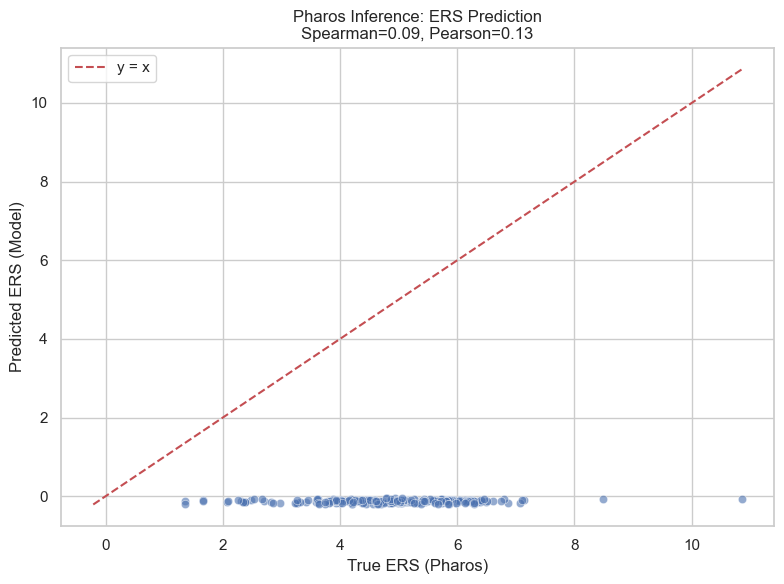

In [ ]:
# Compute correlation using the real data from pharos_df
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation
spearman_corr, _ = spearmanr(pharos_df["ERS"], pharos_df["Inferred_ERS_model"])
pearson_corr, _ = pearsonr(pharos_df["ERS"], pharos_df["Inferred_ERS_model"])

# Plot: True vs Predicted ERS
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pharos_df, x="ERS", y="Inferred_ERS_model", alpha=0.6)

min_val = min(pharos_df["ERS"].min(), pharos_df["Inferred_ERS_model"].min())
max_val = max(pharos_df["ERS"].max(), pharos_df["Inferred_ERS_model"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

plt.xlabel("True ERS (Pharos)")
plt.ylabel("Predicted ERS (Model)")
plt.title(f"Pharos Inference: ERS Prediction\nSpearman={spearman_corr:.2f}, Pearson={pearson_corr:.2f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

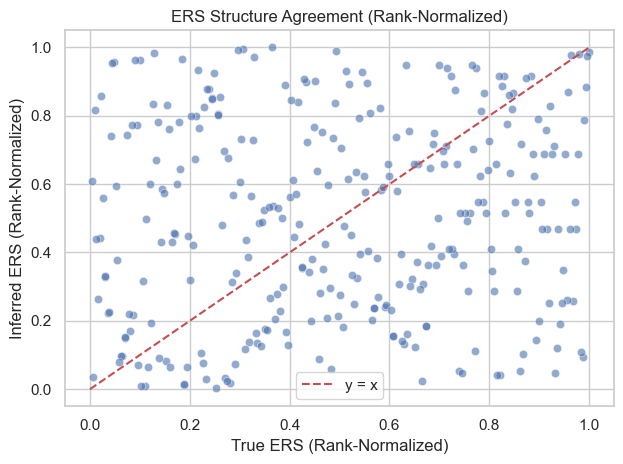

In [ ]:
from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt

pharos_df["ERS_rank"] = rankdata(pharos_df["ERS"]) / len(pharos_df)
pharos_df["Inferred_ERS_rank"] = rankdata(pharos_df["Inferred_ERS_model"]) / len(pharos_df)

sns.scatterplot(data=pharos_df, x="ERS_rank", y="Inferred_ERS_rank", alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--', label='y = x')
plt.xlabel("True ERS (Rank-Normalized)")
plt.ylabel("Inferred ERS (Rank-Normalized)")
plt.title("ERS Structure Agreement (Rank-Normalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

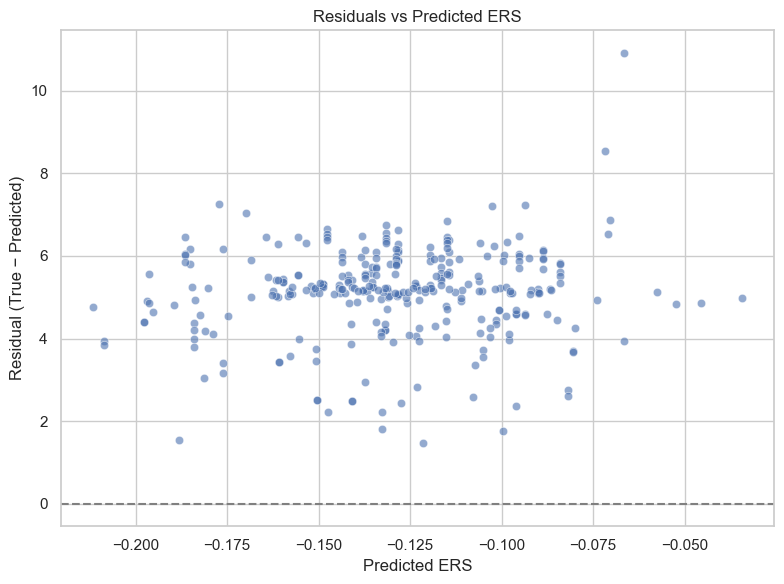

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

pharos_df["Residual_ERS"] = pharos_df["ERS"] - pharos_df["Inferred_ERS_model"]
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pharos_df,
    x="Inferred_ERS_model",
    y="Residual_ERS",
    alpha=0.6
)
plt.axhline(0, linestyle="--", color="gray")
plt.xlabel("Predicted ERS")
plt.ylabel("Residual (True − Predicted)")
plt.title("Residuals vs Predicted ERS")
plt.grid(True)
plt.tight_layout()
plt.show()

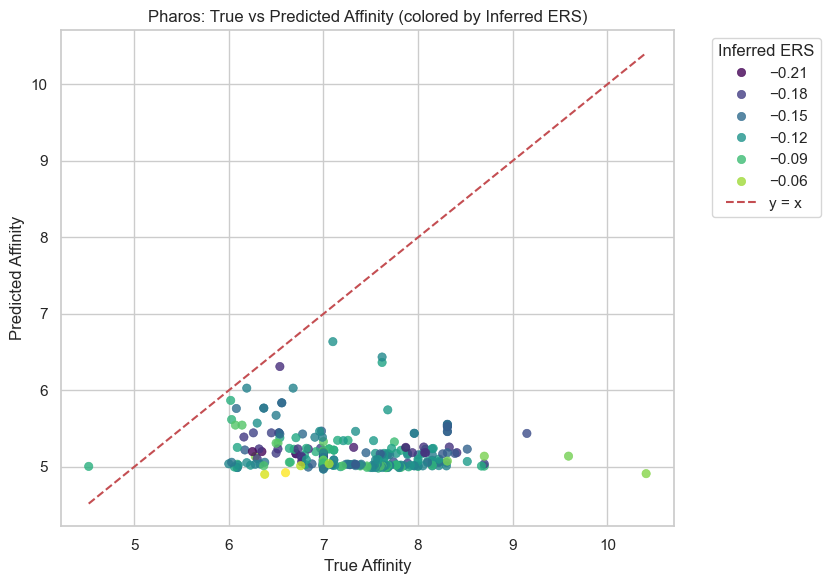

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#filtered_df = pharos_df[pharos_df["Predicted_Value"] < 5]

plt.figure(figsize=(7, 6))
scatter = sns.scatterplot(
    data=pharos_df,
    x="True_Label",
    y="Predicted_Value",
    hue="Inferred_ERS_model",
    palette="viridis",
    alpha=0.8,
    edgecolor=None
)

# Diagonal reference line
plt.plot([pharos_df["True_Label"].min(), pharos_df["True_Label"].max()],
         [pharos_df["True_Label"].min(), pharos_df["True_Label"].max()],
         'r--', label="y = x")

plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("Pharos: True vs Predicted Affinity (colored by Inferred ERS)")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Inferred ERS", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Predicting to Adjust

In [39]:
import pandas as pd
print(davis_outside_df_2.columns)
print(unblinded_df.columns)
# Merge unblinded + blinded on ID columns
davis_outside_df_2.rename(columns={"Predicted_Value": "Blinded_Prediction"}, inplace=True)
unblinded_df.rename(columns={"Predicted_Value": "Unblinded_Prediction"}, inplace=True)
davis_outside_df_2["Drug_ID"] = blinded_df["Drug_ID"].astype(str)
unblinded_df["Drug_ID"] = unblinded_df["Drug_ID"].astype(str)

davis_merged = davis_outside_df_2
# Compute the signed error
davis_merged["Signed_Error"] = davis_merged["Blinded_Prediction"] - davis_merged["True_Label"]

Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Unblinded_Prediction',
       'Predicted_Value', 'Fold', 'DTH', 'ERS', 'CSPD', 'Sparsity_Weight'],
      dtype='object')
Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Predicted_Value'], dtype='object')


In [40]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def mean_similarity_to_train(embedding, train_embeddings):
    sims = cosine_similarity([embedding], train_embeddings)[0]
    return np.mean(sims), np.max(sims)


def compute_similarity_features(df, drug_embs, prot_embs, train_drug_ids, train_prot_ids):
    train_drug_vecs = np.stack([drug_embs[did] for did in train_drug_ids])
    train_prot_vecs = np.stack([prot_embs[pid] for pid in train_prot_ids])

    features = []
    for _, row in df.iterrows():
        try:
            drug_vec = drug_embs[row["Drug_ID"]]
            prot_vec = prot_embs[row["Protein_ID"]]

            drug_sim = cosine_similarity([drug_vec], train_drug_vecs)[0]
            prot_sim = cosine_similarity([prot_vec], train_prot_vecs)[0]

            features.append([
                np.mean(drug_sim), np.max(drug_sim),
                np.mean(prot_sim), np.max(prot_sim)
            ])
        except KeyError:
            features.append([np.nan]*4)

    return pd.DataFrame(features, columns=[
        "Drug_Sim_Mean", "Drug_Sim_Max", "Prot_Sim_Mean", "Prot_Sim_Max"
    ])

In [41]:
# Add similarity to DAVIS
davis_merged = davis_merged[davis_merged["Drug_ID"].isin(davis_drug_embeddings) & davis_merged["Protein_ID"].isin(davis_protein_embeddings)]

davis_sim_feats = compute_similarity_features(
    davis_merged,
    drug_embs=davis_drug_embeddings,
    prot_embs=davis_protein_embeddings,
    train_drug_ids=davis_drug_ids,
    train_prot_ids=davis_protein_ids
)
davis_merged = pd.concat([davis_merged.reset_index(drop=True), davis_sim_feats], axis=1)


print(davis_merged.columns)

#from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
reg = HistGradientBoostingRegressor(max_iter=300)
# Features for training (blinded prediction + similarities)
# X_train = davis_merged[["Blinded_Prediction", "Drug_Sim_Mean", "Drug_Sim_Max", "Prot_Sim_Mean", "Prot_Sim_Max"]]
# X_train["CSPD"] = davis_merged["CSPD"]
# Add flag directly to the source DataFrame
min_davis_unblinded = davis_merged["Unblinded_Prediction"].min()
davis_merged["Below_Train_Min"] = (davis_merged["Blinded_Prediction"] < min_davis_unblinded).astype(int)
davis_merged["Confidence_Proxy"] = davis_merged["Drug_Sim_Mean"] * davis_merged["Prot_Sim_Mean"]


# Now construct X_train cleanly
X_train = davis_merged[[
    "Blinded_Prediction", "Drug_Sim_Mean", "Drug_Sim_Max",
    "Prot_Sim_Mean", "Prot_Sim_Max", "CSPD", "Confidence_Proxy"
]]

y_train = davis_merged["Signed_Error"]

#reg = RandomForestRegressor(n_estimators=200, random_state=42)
reg.fit(X_train, y_train)
from sklearn.inspection import permutation_importance

result = permutation_importance(
    reg, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1
)

# Assemble into DataFrame
perm_importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": result.importances_mean,
    "Std": result.importances_std
}).sort_values(by="Importance", ascending=False)

print(perm_importances)


Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Unblinded_Prediction',
       'Blinded_Prediction', 'Fold', 'DTH', 'ERS', 'CSPD', 'Sparsity_Weight',
       'Signed_Error', 'Drug_Sim_Mean', 'Drug_Sim_Max', 'Prot_Sim_Mean',
       'Prot_Sim_Max'],
      dtype='object')
              Feature  Importance       Std
3       Prot_Sim_Mean    0.377173  0.005667
0  Blinded_Prediction    0.231463  0.004828
4        Prot_Sim_Max    0.136339  0.002180
6    Confidence_Proxy    0.024000  0.001018
1       Drug_Sim_Mean    0.023343  0.000547
2        Drug_Sim_Max    0.010678  0.000725
5                CSPD    0.000000  0.000000


In [42]:
# Compute similarity features to DAVIS training set
pharos_sim_feats = compute_similarity_features(
    pharos_df,
    drug_embs=pharos_drug_embeddings,
    prot_embs=pharos_protein_embeddings,
    train_drug_ids=pharos_drug_ids,
    train_prot_ids=pharos_protein_ids
)

# Combine similarity features with main dataframe
pharos_df_sim = pd.concat([pharos_df.reset_index(drop=True), pharos_sim_feats], axis=1)

# Rename prediction column if needed
pharos_df_sim = pharos_df_sim.rename(columns={"Predicted_Value": "Blinded_Prediction"})

# Prepare features for prediction
# X_pharos = pharos_df_sim[["Blinded_Prediction", "Drug_Sim_Mean", "Drug_Sim_Max", "Prot_Sim_Mean", "Prot_Sim_Max"]]
pharos_df_sim["CSPD"] = np.nan
pharos_df_sim["Below_Train_Min"] = (pharos_df_sim["Blinded_Prediction"] < min_davis_unblinded).astype(int)
pharos_df_sim["Confidence_Proxy"] = (
    pharos_df_sim["Drug_Sim_Mean"] * pharos_df_sim["Prot_Sim_Mean"]
)

X_pharos = pharos_df_sim[[
    "Blinded_Prediction",
    "Drug_Sim_Mean", "Drug_Sim_Max",
    "Prot_Sim_Mean", "Prot_Sim_Max",
    "CSPD","Confidence_Proxy"
]]

print(reg.feature_names_in_)
print(X_pharos.columns)


# Predict signed error
pharos_df_sim["Predicted_Error"] = reg.predict(X_pharos)

# Adjust prediction
pharos_df_sim["Adjusted_Prediction"] = pharos_df_sim["Blinded_Prediction"] - pharos_df_sim["Predicted_Error"]

['Blinded_Prediction' 'Drug_Sim_Mean' 'Drug_Sim_Max' 'Prot_Sim_Mean'
 'Prot_Sim_Max' 'CSPD' 'Confidence_Proxy']
Index(['Blinded_Prediction', 'Drug_Sim_Mean', 'Drug_Sim_Max', 'Prot_Sim_Mean',
       'Prot_Sim_Max', 'CSPD', 'Confidence_Proxy'],
      dtype='object')


In [43]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

true = pharos_df_sim["True_Label"]
orig = pharos_df_sim["Blinded_Prediction"]
adj = pharos_df_sim["Adjusted_Prediction"]

print("Original RMSE:", np.sqrt(mean_squared_error(true, orig)))
print("Adjusted RMSE:", np.sqrt(mean_squared_error(true, adj)))
print("Original MAE:", np.sqrt(mean_absolute_error(true, orig)))
print("Adjusted MAE:", np.sqrt(mean_absolute_error(true, adj)))

Original RMSE: 2.238207528426001
Adjusted RMSE: 2.0124479062716545
Original MAE: 1.4529371741185109
Adjusted MAE: 1.3661738836711086


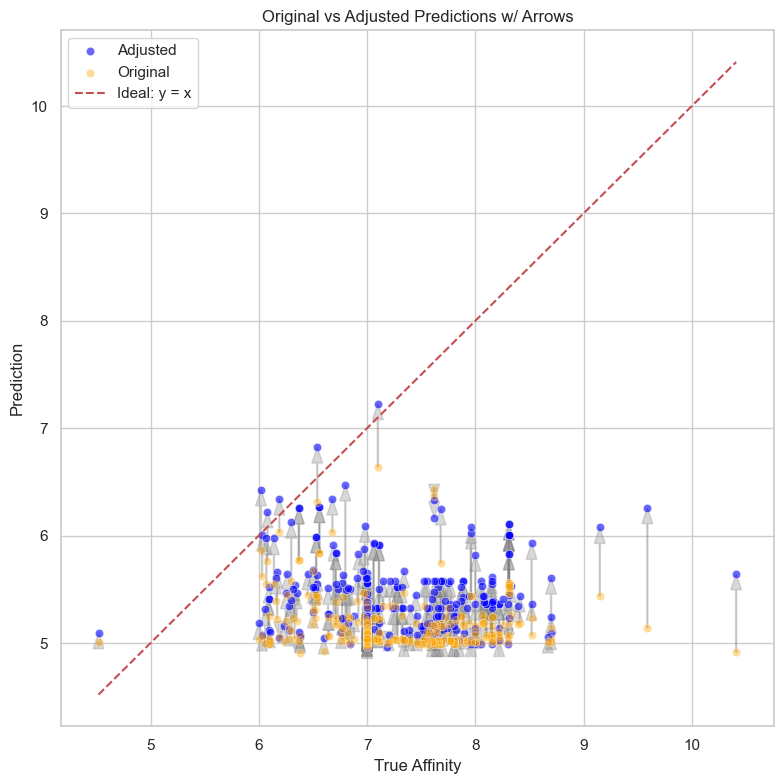

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))

# Plot arrows: original → adjusted
for _, row in pharos_df_sim.iterrows():
    plt.arrow(
        row["True_Label"], row["Blinded_Prediction"],
        0, row["Adjusted_Prediction"] - row["Blinded_Prediction"],
        color='gray', alpha=0.3, width=0.01, head_width=0.1, length_includes_head=True
    )

# Scatter adjusted points
sns.scatterplot(
    x=pharos_df_sim["True_Label"],
    y=pharos_df_sim["Adjusted_Prediction"],
    color="blue", label="Adjusted", alpha=0.6
)

# Scatter original predictions
sns.scatterplot(
    x=pharos_df_sim["True_Label"],
    y=pharos_df_sim["Blinded_Prediction"],
    color="orange", label="Original", alpha=0.4
)

# y = x line
lims = [
    min(pharos_df_sim["True_Label"].min(), pharos_df_sim["Blinded_Prediction"].min(), pharos_df_sim["Adjusted_Prediction"].min()),
    max(pharos_df_sim["True_Label"].max(), pharos_df_sim["Blinded_Prediction"].max(), pharos_df_sim["Adjusted_Prediction"].max())
]
plt.plot(lims, lims, 'r--', label='Ideal: y = x')

plt.xlabel("True Affinity")
plt.ylabel("Prediction")
plt.title("Original vs Adjusted Predictions w/ Arrows")
plt.legend()
plt.tight_layout()
plt.show()

### Using just affinity bins to shift

In [45]:
print(pharos_df_sim.columns)

Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Blinded_Prediction',
       'Inferred_ERS', 'ERS_Confidence', 'Inferred_CSVS_alt', 'ERS',
       'ERS_rank', 'Inferred_ERS_rank', 'Drug_Sim_Mean', 'Drug_Sim_Max',
       'Prot_Sim_Mean', 'Prot_Sim_Max', 'CSPD', 'Below_Train_Min',
       'Confidence_Proxy', 'Predicted_Error', 'Adjusted_Prediction'],
      dtype='object')


27620
📊 Average Signed Error per Predicted Affinity Bin (from DAVIS):

  Bin (4, 5]:  -0.131
  Bin (5, 6]:  -0.214
  Bin (6, 7]:  -0.162
  Bin (7, 8]:  -0.077
  Bin (8, 9]:  +0.030
  Bin (9, 10]:  -0.241


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_74061/4114858339.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = davis_merged.groupby(pd.cut(davis_merged["Blinded_Prediction"], bins=[4, 5, 6, 7, 8, 9, 10]))["Signed_Error"].mean()


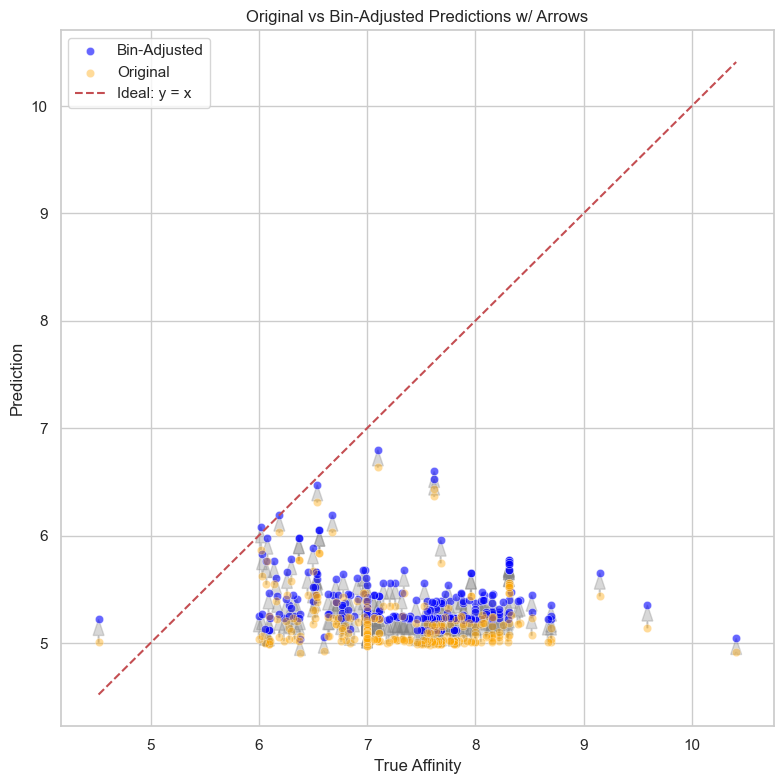

Original RMSE: 2.238
Regressor-Adjusted RMSE: 2.012
Bin-Adjusted RMSE: 2.046


In [46]:
### Using just affinity bins to shift
pharos_df_sim["Affinity_Bin"] = pd.cut(pharos_df_sim["Blinded_Prediction"], bins=[4, 5, 6, 7, 8, 9, 10])
print(len(davis_merged))
# On DAVIS: compute mean signed error per bin
bin_means = davis_merged.groupby(pd.cut(davis_merged["Blinded_Prediction"], bins=[4, 5, 6, 7, 8, 9, 10]))["Signed_Error"].mean()
print("📊 Average Signed Error per Predicted Affinity Bin (from DAVIS):\n")
for bin_range, correction in bin_means.items():
    print(f"  Bin {bin_range}:  {correction:+.3f}")

# Apply to Pharos
pharos_df_sim["Bin_Correction"] = pharos_df_sim["Affinity_Bin"].map(bin_means)
pharos_df_sim["Bin_Correction"] = pd.to_numeric(pharos_df_sim["Bin_Correction"], errors="coerce")
pharos_df_sim["Bin_Adjusted"] = pharos_df_sim["Blinded_Prediction"] - pharos_df_sim["Bin_Correction"]

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))

# Plot arrows: original → bin-adjusted
for _, row in pharos_df_sim.iterrows():
    plt.arrow(
        row["True_Label"], row["Blinded_Prediction"],
        0, row["Bin_Adjusted"] - row["Blinded_Prediction"],
        color='gray', alpha=0.3, width=0.01, head_width=0.1, length_includes_head=True
    )

# Scatter bin-adjusted predictions
sns.scatterplot(
    x=pharos_df_sim["True_Label"],
    y=pharos_df_sim["Bin_Adjusted"],
    color="blue", label="Bin-Adjusted", alpha=0.6
)

# Scatter original predictions
sns.scatterplot(
    x=pharos_df_sim["True_Label"],
    y=pharos_df_sim["Blinded_Prediction"],
    color="orange", label="Original", alpha=0.4
)

# y = x line
lims = [
    min(pharos_df_sim["True_Label"].min(),
        pharos_df_sim["Blinded_Prediction"].min(),
        pharos_df_sim["Bin_Adjusted"].min()),
    max(pharos_df_sim["True_Label"].max(),
        pharos_df_sim["Blinded_Prediction"].max(),
        pharos_df_sim["Bin_Adjusted"].max())
]
plt.plot(lims, lims, 'r--', label='Ideal: y = x')

plt.xlabel("True Affinity")
plt.ylabel("Prediction")
plt.title("Original vs Bin-Adjusted Predictions w/ Arrows")
plt.legend()
plt.tight_layout()
plt.show()

from sklearn.metrics import mean_squared_error
import numpy as np

# RMSE before any correction
rmse_orig = np.sqrt(mean_squared_error(pharos_df_sim["True_Label"], pharos_df_sim["Blinded_Prediction"]))

# RMSE after regressor-based correction
rmse_reg = np.sqrt(mean_squared_error(pharos_df_sim["True_Label"], pharos_df_sim["Adjusted_Prediction"]))

# RMSE after bin-based correction
rmse_bin = np.sqrt(mean_squared_error(pharos_df_sim["True_Label"], pharos_df_sim["Bin_Adjusted"]))

print(f"Original RMSE: {rmse_orig:.3f}")
print(f"Regressor-Adjusted RMSE: {rmse_reg:.3f}")
print(f"Bin-Adjusted RMSE: {rmse_bin:.3f}")


### Using bins but incorporating CSPD and unblinded prediction error as well

/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_74061/3252555070.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  blinding_bias = davis_merged.groupby("Affinity_Bin")["Δ_blinding"].mean()
/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_74061/3252555070.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unblinded_error = davis_merged.groupby("Affinity_Bin")["Δ_unblinded_error"].mean()


Combined Adjustment RMSE: 1.856


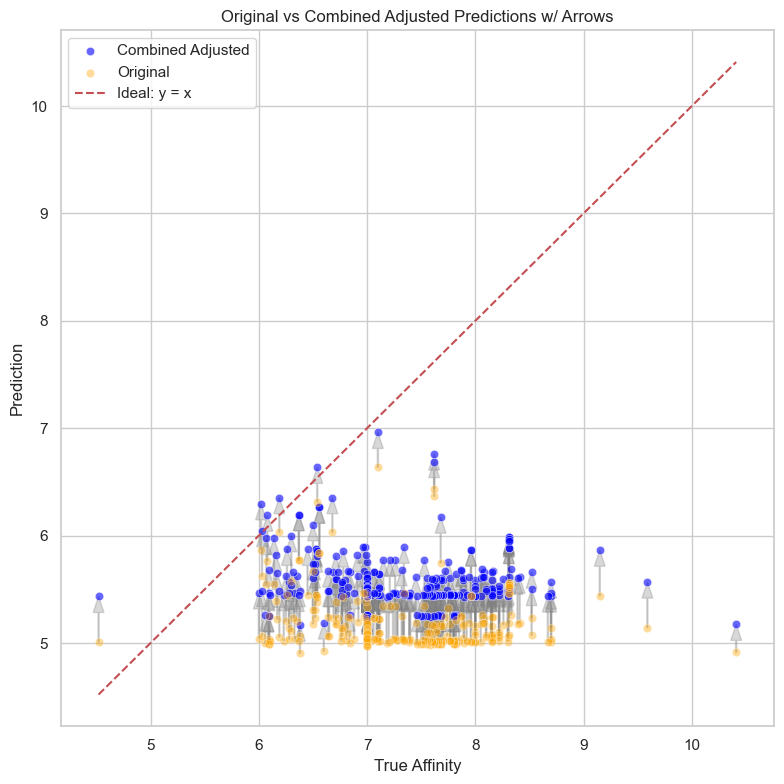

In [47]:
### Using bins but incorporating CSPD and unblinded prediction error as well
davis_merged["Δ_blinding"] = davis_merged["Blinded_Prediction"] - davis_merged["Unblinded_Prediction"]
davis_merged["Δ_unblinded_error"] = davis_merged["Unblinded_Prediction"] - davis_merged["True_Label"]

# Bin by Blinded_Prediction
bins = [4, 5, 6, 7, 8, 9, 10]
davis_merged["Affinity_Bin"] = pd.cut(davis_merged["Blinded_Prediction"], bins=bins)

# Compute bin-wise means
blinding_bias = davis_merged.groupby("Affinity_Bin")["Δ_blinding"].mean()
unblinded_error = davis_merged.groupby("Affinity_Bin")["Δ_unblinded_error"].mean()

pharos_df_sim["Affinity_Bin"] = pd.cut(pharos_df_sim["Blinded_Prediction"], bins=bins)

# Map corrections
pharos_df_sim["Bin_Blinding_Bias"] = pharos_df_sim["Affinity_Bin"].map(blinding_bias)
pharos_df_sim["Bin_Unblinded_Error"] = pharos_df_sim["Affinity_Bin"].map(unblinded_error)

# Ensure all mapped columns are numeric before fillna + arithmetic
for col in ["Bin_Blinding_Bias", "Bin_Unblinded_Error", "Bin_Correction"]:
    pharos_df_sim[col] = pd.to_numeric(pharos_df_sim[col], errors="coerce")

# Total correction = both components
pharos_df_sim["Combined_Correction"] = (
    pharos_df_sim["Bin_Blinding_Bias"].fillna(0) + 
    pharos_df_sim["Bin_Unblinded_Error"].fillna(0) + 
    pharos_df_sim["Bin_Correction"].fillna(0)
)

# Adjust prediction
pharos_df_sim["Combined_Adjusted"] = pharos_df_sim["Blinded_Prediction"] - pharos_df_sim["Combined_Correction"]

from sklearn.metrics import mean_squared_error
import numpy as np

true = pharos_df_sim["True_Label"]

rmse_combined = np.sqrt(mean_squared_error(true, pharos_df_sim["Combined_Adjusted"]))

print(f"Combined Adjustment RMSE: {rmse_combined:.3f}")

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))

# Plot arrows: original → combined-adjusted
for _, row in pharos_df_sim.iterrows():
    plt.arrow(
        row["True_Label"], row["Blinded_Prediction"],
        0, row["Combined_Adjusted"] - row["Blinded_Prediction"],
        color='gray', alpha=0.3, width=0.01, head_width=0.1, length_includes_head=True
    )

# Scatter combined-adjusted predictions
sns.scatterplot(
    x=pharos_df_sim["True_Label"],
    y=pharos_df_sim["Combined_Adjusted"],
    color="blue", label="Combined Adjusted", alpha=0.6
)

# Scatter original predictions
sns.scatterplot(
    x=pharos_df_sim["True_Label"],
    y=pharos_df_sim["Blinded_Prediction"],
    color="orange", label="Original", alpha=0.4
)

# y = x line (ideal prediction)
lims = [
    min(pharos_df_sim["True_Label"].min(),
        pharos_df_sim["Blinded_Prediction"].min(),
        pharos_df_sim["Combined_Adjusted"].min()),
    max(pharos_df_sim["True_Label"].max(),
        pharos_df_sim["Blinded_Prediction"].max(),
        pharos_df_sim["Combined_Adjusted"].max())
]
plt.plot(lims, lims, 'r--', label='Ideal: y = x')

plt.xlabel("True Affinity")
plt.ylabel("Prediction")
plt.title("Original vs Combined Adjusted Predictions w/ Arrows")
plt.legend()
plt.tight_layout()
plt.show()


### Combined but also weighting by prediction commonness of pharos predictions
 - less common -> more weight -> larger shift

Weighted Combined Adjustment RMSE: 1.739


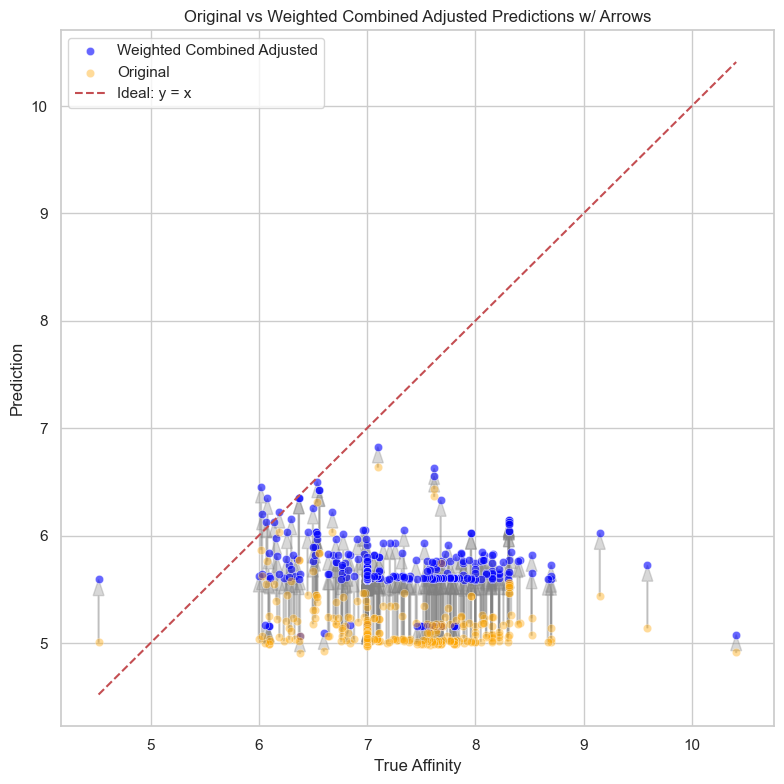

In [48]:

davis_merged["Affinity_Bin"] = pd.cut(davis_merged["Unblinded_Prediction"], bins=bins)
davis_bin_counts = davis_merged["Affinity_Bin"].value_counts(normalize=True).sort_index()
pharos_bin_counts = pharos_df_sim["Affinity_Bin"].value_counts(normalize=True).sort_index()
# How rare a bin is in DAVIS compared to how often it appears in Pharos
bin_weight = pharos_bin_counts / davis_bin_counts
bin_weight = bin_weight.fillna(0)  # Handle divide-by-zero safely
# Apply weights to bin-based components
pharos_df_sim["Bin_Weight"] = pharos_df_sim["Affinity_Bin"].map(bin_weight)

pharos_df_sim["Weighted_Blinding_Bias"] = pharos_df_sim["Bin_Blinding_Bias"] * pharos_df_sim["Bin_Weight"]
pharos_df_sim["Weighted_Unblinded_Error"] = pharos_df_sim["Bin_Unblinded_Error"] * pharos_df_sim["Bin_Weight"]

# Combined correction (amplified or dampened per bin)
pharos_df_sim["Weighted_Combined_Correction"] = (
    pharos_df_sim["Weighted_Blinding_Bias"].fillna(0) + 
    pharos_df_sim["Weighted_Unblinded_Error"].fillna(0) + 
    pharos_df_sim["Bin_Correction"].fillna(0)
)

pharos_df_sim["Weighted_Combined_Adjusted"] = (
    pharos_df_sim["Blinded_Prediction"] - pharos_df_sim["Weighted_Combined_Correction"]
)
rmse_weighted_combined = np.sqrt(mean_squared_error(true, pharos_df_sim["Weighted_Combined_Adjusted"]))
print(f"Weighted Combined Adjustment RMSE: {rmse_weighted_combined:.3f}")
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))

# Plot arrows: original → weighted combined adjusted
for _, row in pharos_df_sim.iterrows():
    plt.arrow(
        row["True_Label"], row["Blinded_Prediction"],
        0, row["Weighted_Combined_Adjusted"] - row["Blinded_Prediction"],
        color='gray', alpha=0.3, width=0.01, head_width=0.1, length_includes_head=True
    )

# Scatter weighted adjusted predictions
sns.scatterplot(
    x=pharos_df_sim["True_Label"],
    y=pharos_df_sim["Weighted_Combined_Adjusted"],
    color="blue", label="Weighted Combined Adjusted", alpha=0.6
)

# Scatter original predictions
sns.scatterplot(
    x=pharos_df_sim["True_Label"],
    y=pharos_df_sim["Blinded_Prediction"],
    color="orange", label="Original", alpha=0.4
)

# y = x line (ideal prediction)
lims = [
    min(pharos_df_sim["True_Label"].min(),
        pharos_df_sim["Blinded_Prediction"].min(),
        pharos_df_sim["Weighted_Combined_Adjusted"].min()),
    max(pharos_df_sim["True_Label"].max(),
        pharos_df_sim["Blinded_Prediction"].max(),
        pharos_df_sim["Weighted_Combined_Adjusted"].max())
]
plt.plot(lims, lims, 'r--', label='Ideal: y = x')

plt.xlabel("True Affinity")
plt.ylabel("Prediction")
plt.title("Original vs Weighted Combined Adjusted Predictions w/ Arrows")
plt.legend()
plt.tight_layout()
plt.show()


# Arties Idea
Plot similarity vs percent error

Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Unblinded_Prediction',
       'Blinded_Prediction'],
      dtype='object')


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_74061/1925209499.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


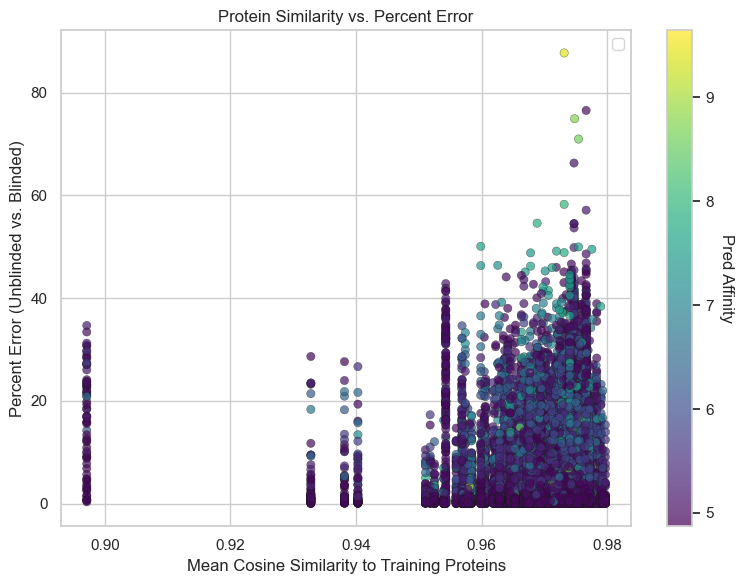

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics.pairwise import cosine_similarity

# === Load your merged dataframe (example column names) ===
# merged_df = pd.read_csv("merged_predictions.csv")
# Columns: Protein_ID, True_Label, Unblinded_Prediction, Blinded_Prediction

# === Assume you have this dict from esm1b embeddings or similar ===
# protein_embeddings = { "P12345": np.array([...]), ... }

# === Compute similarity of each protein to the training proteins ===
def build_protein_similarity_cache(protein_embeddings, train_proteins, save_path="protein_similarity_cache.pkl"):
    similarity_cache = {}
    train_embeddings = {
        pid: protein_embeddings[pid]
        for pid in train_proteins if pid in protein_embeddings
    }
    for pid in protein_embeddings:
        if pid not in similarity_cache:
            query = protein_embeddings[pid].reshape(1, -1)
            train_vecs = np.array(list(train_embeddings.values()))
            if train_vecs.size == 0:
                similarity_cache[pid] = np.nan
            else:
                sim = cosine_similarity(query, train_vecs)[0]
                similarity_cache[pid] = np.mean(sim)  # or np.max(sim)

    with open(save_path, "wb") as f:
        pickle.dump(similarity_cache, f)

    return similarity_cache

# === Step 3: Load or build the cache ===
train_proteins = merged_df["Protein_ID"]
similarity_cache = build_protein_similarity_cache(protein_embeddings, train_proteins)

# === Step 4: Apply to DataFrame ===
davis_outside = davis_outside_df.rename(columns={"Predicted_Value":"Blinded_Prediction"})
unblinded_df = unblinded_df.rename(columns={"Predicted_Value":"Unblinded_Prediction"})
davis_outside["Drug_ID"] = davis_outside["Drug_ID"].astype(str)
unblinded_df["Drug_ID"] = unblinded_df["Drug_ID"].astype(str)
merged_df_outside = pd.merge(
    unblinded_df[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    davis_outside[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)
df = merged_df_outside.copy()
print(df.columns)
df["Percent_Error"] = 100 * np.abs(df["Unblinded_Prediction"] - df["Blinded_Prediction"]) / df["True_Label"]

df["Protein_Similarity"] = df["Protein_ID"].map(similarity_cache)


df_clean = df.dropna(subset=["Protein_Similarity", "Percent_Error"])


# === Plot ===
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_clean["Protein_Similarity"],
    df_clean["Percent_Error"],
    c=df_clean["Blinded_Prediction"],
    cmap="viridis",
    alpha=0.7,
    edgecolor='k',
    linewidth=0.3
)
# Colorbar
cbar = plt.colorbar(scatter)
cbar.set_label("Pred Affinity", rotation=270, labelpad=15)

# Labels and title
plt.xlabel("Mean Cosine Similarity to Training Proteins")
plt.ylabel("Percent Error (Unblinded vs. Blinded)")
plt.title("Protein Similarity vs. Percent Error")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


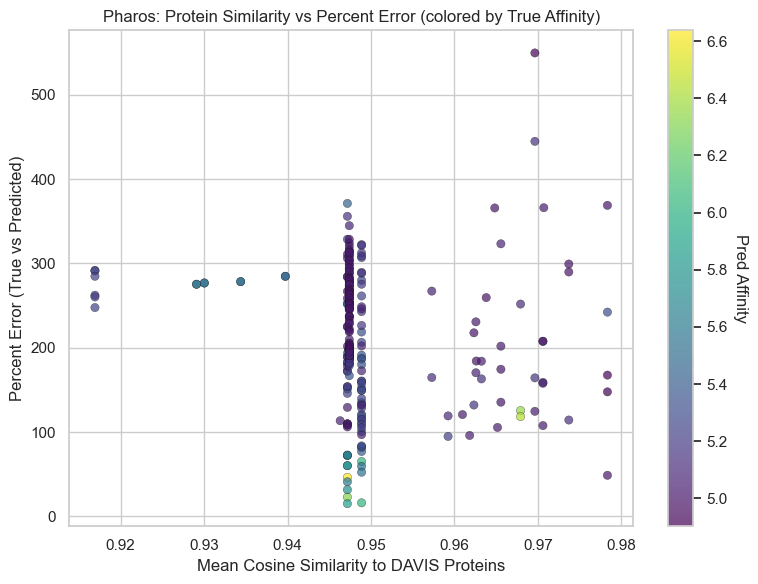

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pickle

def build_similarity_cache_pharos_to_davis(pharos_embeddings, davis_embeddings, save_path="pharos_to_davis_similarity.pkl"):
    similarity_cache = {}
    davis_vecs = np.array(list(davis_embeddings.values()))
    for pid, emb in pharos_embeddings.items():
        if emb is not None and davis_vecs.size > 0:
            sim = cosine_similarity([emb], davis_vecs)[0]
            similarity_cache[pid] = np.mean(sim)  # or np.max(sim)
        else:
            similarity_cache[pid] = np.nan

    with open(save_path, "wb") as f:
        pickle.dump(similarity_cache, f)

    return similarity_cache

# === Step 1: Load or build similarity cache ===
try:
    with open("pharos_to_davis_similarity.pkl", "rb") as f:
        pharos_sim_cache = pickle.load(f)
except FileNotFoundError:
    pharos_sim_cache = build_similarity_cache_pharos_to_davis(
        pharos_protein_embeddings, davis_protein_embeddings
    )

# === Step 2: Load Pharos prediction dataframe ===
# Required columns: Protein_ID, True_Label, Predicted_Value

# === Step 3: Add similarity and percent error ===
pharos_df["Protein_Similarity"] = pharos_df["Protein_ID"].map(pharos_sim_cache)
pharos_df["Percent_Error"] = 100 * np.abs(pharos_df["True_Label"] - pharos_df["Predicted_Value"])

# === Step 4: Plot ===
df_clean = pharos_df.dropna(subset=["Protein_Similarity", "Percent_Error", "True_Label"])

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_clean["Protein_Similarity"],
    df_clean["Percent_Error"],
    c=df_clean["Predicted_Value"],
    cmap="viridis",  # Choose any colormap like "plasma", "coolwarm", etc.
    alpha=0.7,
    edgecolor='k',
    linewidth=0.3
)

cbar = plt.colorbar(scatter)
cbar.set_label("Pred Affinity", rotation=270, labelpad=15)

plt.xlabel("Mean Cosine Similarity to DAVIS Proteins")
plt.ylabel("Percent Error (True vs Predicted)")
plt.title("Pharos: Protein Similarity vs Percent Error (colored by True Affinity)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [53]:
print(df_clean.columns)
df_clean.rename(columns={"Predicted_Value":"Blinded_Prediction"},inplace=True)

Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Predicted_Value',
       'Inferred_ERS', 'ERS_Confidence', 'Inferred_CSVS_alt', 'ERS',
       'ERS_rank', 'Inferred_ERS_rank', 'Protein_Similarity', 'Percent_Error'],
      dtype='object')


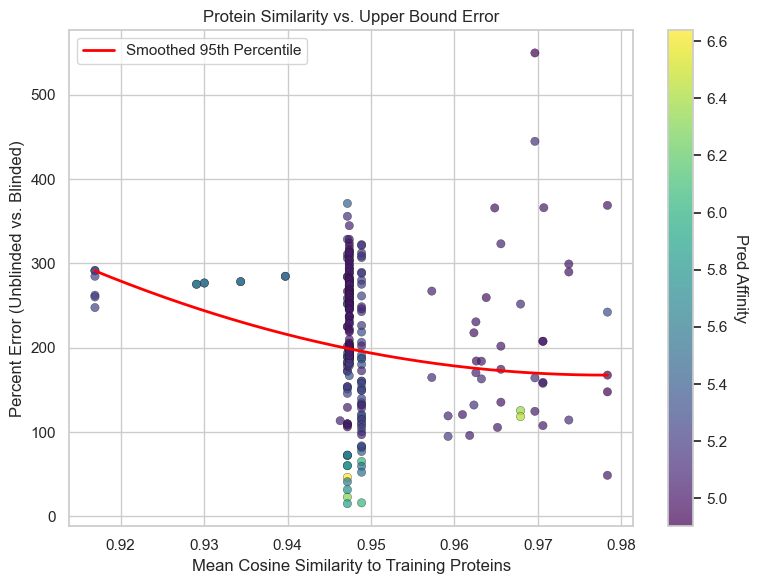

In [54]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

# Define the predictors and target
X = df_clean["Protein_Similarity"]
y = df_clean["Percent_Error"]

# Add constant for intercept
X_poly = np.column_stack([X, X**2])
X_poly = sm.add_constant(X_poly)

# Fit quantile regression model at 95th percentile
mod = sm.QuantReg(y, X_poly)
res = mod.fit(q=0.50)

# Predict on a grid
x_vals = np.linspace(X.min(), X.max(), 300)
x_poly_vals = np.column_stack([x_vals, x_vals**2])
x_poly_vals = sm.add_constant(x_poly_vals)
y_pred = res.predict(x_poly_vals)

# Plot scatter + smooth quantile curve
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_clean["Protein_Similarity"],
    df_clean["Percent_Error"],
    c=df_clean["Blinded_Prediction"],
    cmap="viridis",
    alpha=0.7,
    edgecolor='k',
    linewidth=0.3
)

# Plot the quantile fit
plt.plot(x_vals, y_pred, color='red', linewidth=2, label="Smoothed 95th Percentile")

# Colorbar and labels
cbar = plt.colorbar(scatter)
cbar.set_label("Pred Affinity", rotation=270, labelpad=15)
plt.xlabel("Mean Cosine Similarity to Training Proteins")
plt.ylabel("Percent Error (Unblinded vs. Blinded)")
plt.title("Protein Similarity vs. Upper Bound Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


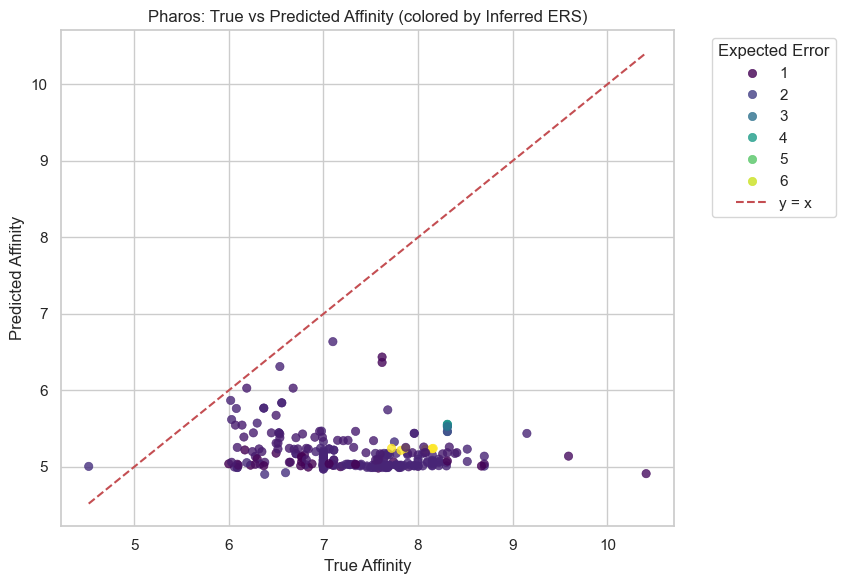

In [55]:
# Fit quadratic quantile regression
X = df["Protein_Similarity"]
y = df["Percent_Error"]
X_poly = sm.add_constant(np.column_stack([X, X**2]))
model = sm.QuantReg(y, X_poly).fit(q=0.50)

def predict_expected_error(similarity, model):
    """Predict expected 95th percentile error from similarity using trained quantile model."""
    X_new = np.column_stack([similarity, similarity**2])
    X_new = sm.add_constant(X_new, has_constant='add')
    return model.predict(X_new)

pharos_df["Expected_Error"] = predict_expected_error(pharos_df["Protein_Similarity"].values, model)
import matplotlib.pyplot as plt
import seaborn as sns
#filtered_df = pharos_df[pharos_df["Predicted_Value"] < 5]

plt.figure(figsize=(7, 6))
scatter = sns.scatterplot(
    data=pharos_df,
    x="True_Label",
    y="Predicted_Value",
    hue="Expected_Error",
    palette="viridis",
    alpha=0.8,
    edgecolor=None
)

# Diagonal reference line
plt.plot([pharos_df["True_Label"].min(), pharos_df["True_Label"].max()],
         [pharos_df["True_Label"].min(), pharos_df["True_Label"].max()],
         'r--', label="y = x")

plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("Pharos: True vs Predicted Affinity (colored by Inferred ERS)")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Expected Error", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

68
Rows in df_clean: 27621
   Drug_Similarity  Percent_Error  Blinded_Prediction
0         0.224694       0.792322            4.961755
1         0.309189       2.478934            5.212859
2         0.319665       0.051350            5.020662
3         0.322870      14.139431            6.183473
4         0.436217       0.521694            5.015148


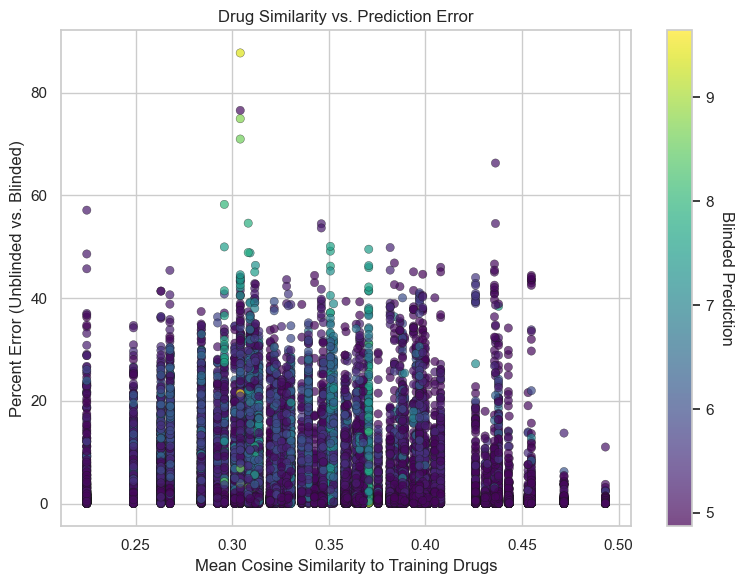

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pickle

# === Compute similarity of each drug to the training drugs ===
def build_drug_similarity_cache(drug_embeddings, train_drugs, save_path="drug_similarity_cache.pkl"):
    similarity_cache = {}
    train_embeddings = {
        did: drug_embeddings[did]
        for did in train_drugs if did in drug_embeddings
    }
    print(len(train_embeddings))

    train_vecs = np.array(list(train_embeddings.values()))
    for did, query_vec in drug_embeddings.items():
        if did not in similarity_cache:
            if query_vec is None or train_vecs.size == 0:
                similarity_cache[did] = np.nan
            else:
                sim = cosine_similarity([query_vec], train_vecs)[0]
                similarity_cache[did] = np.mean(sim)  # or np.max(sim)

    with open(save_path, "wb") as f:
        pickle.dump(similarity_cache, f)

    # Check example IDs and values
    return similarity_cache

# === Step 1: Set training drugs ===
train_drugs = set(merged_df["Drug_ID"].astype(str))
merged_df["Drug_ID"] = merged_df["Drug_ID"].astype(str)

# === Step 2: Load or build the cache ===
# try:
#     with open("drug_similarity_cache.pkl", "rb") as f:
#         similarity_cache = pickle.load(f)
# except FileNotFoundError:
similarity_cache = build_drug_similarity_cache(drug_embeddings, train_drugs)

# === Step 3: Apply to DataFrame ===
df = merged_df.copy()
df["Percent_Error"] = 100 * np.abs(df["Unblinded_Prediction"] - df["Blinded_Prediction"]) / df["True_Label"]
df["Drug_Similarity"] = df["Drug_ID"].map(similarity_cache)

# === Step 4: Plot ===

df_clean = df.dropna(subset=["Drug_Similarity", "Percent_Error"])
print("Rows in df_clean:", len(df_clean))
print(df_clean[["Drug_Similarity", "Percent_Error", "Blinded_Prediction"]].head())

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_clean["Drug_Similarity"],
    df_clean["Percent_Error"],
    c=df_clean["Blinded_Prediction"],
    cmap="viridis",
    alpha=0.7,
    edgecolor='k',
    linewidth=0.3
)

cbar = plt.colorbar(scatter)
cbar.set_label("Blinded Prediction", rotation=270, labelpad=15)

plt.xlabel("Mean Cosine Similarity to Training Drugs")
plt.ylabel("Percent Error (Unblinded vs. Blinded)")
plt.title("Drug Similarity vs. Prediction Error")
plt.grid(True)
plt.tight_layout()
plt.show()

✅ Loaded cache from file
Rows in df_clean: 310
   Drug_Similarity  Percent_Error  Predicted_Value
0         0.395308      16.469738         6.365006
1         0.442153      33.137733         5.556254
2         0.442153      33.313422         5.541655
3         0.442153      33.508937         5.525407
4         0.442153      34.271957         5.462000


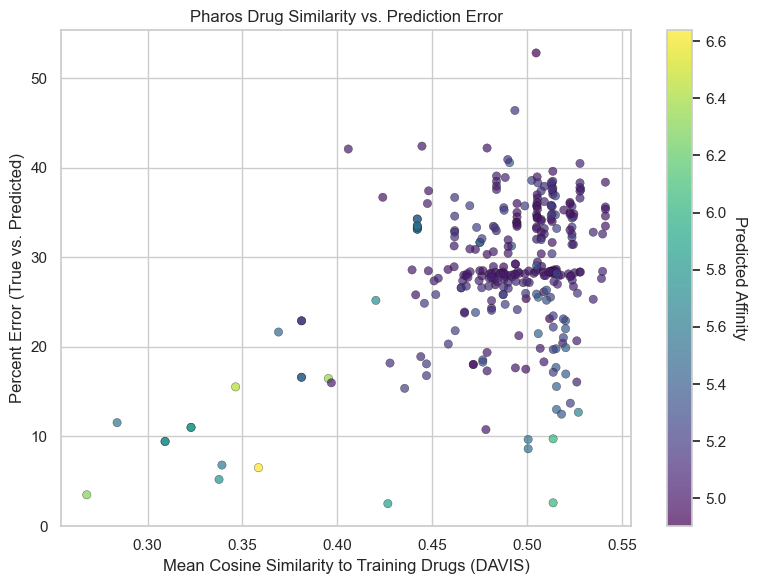

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pickle

# === Compute similarity of each Pharos drug to DAVIS training drugs ===
def build_pharos_drug_similarity_cache(pharos_embeddings, davis_embeddings, save_path="pharos_drug_similarity_cache.pkl"):
    similarity_cache = {}
    print(f"📦 Building similarity cache with {len(pharos_embeddings)} Pharos drugs and {len(davis_embeddings)} DAVIS drugs.")

    train_vecs = np.array(list(davis_embeddings.values()))
    for i, (did, query_vec) in enumerate(pharos_embeddings.items()):
        if query_vec is None or train_vecs.size == 0:
            similarity_cache[did] = np.nan
        else:
            sim = cosine_similarity([query_vec], train_vecs)[0]
            similarity_cache[did] = np.mean(sim)

        if i % 100 == 0:
            print(f"🔄 Processed {i}/{len(pharos_embeddings)} drugs")

    with open(save_path, "wb") as f:
        pickle.dump(similarity_cache, f)

    print("✅ Cache built and saved")
    print("Sample keys in cache:", list(similarity_cache.keys())[:5])
    print("Sample values:", list(similarity_cache.values())[:5])
    return similarity_cache

# === Load and prep your data ===
pharos_df["Drug_ID"] = pharos_df["Drug_ID"].astype(str)
pharos_drug_embeddings = {str(k): v for k, v in pharos_drug_embeddings.items()}
davis_drug_embeddings = {str(k): v for k, v in davis_drug_embeddings.items()}

# === Step 1: Load or build cache ===
try:
    with open("pharos_drug_similarity_cache.pkl", "rb") as f:
        similarity_cache = pickle.load(f)
    print("✅ Loaded cache from file")
except FileNotFoundError:
    similarity_cache = build_pharos_drug_similarity_cache(
        pharos_drug_embeddings,
        davis_drug_embeddings
    )

# === Step 2: Apply similarity + percent error ===
df = pharos_df.copy()
df["Drug_Similarity"] = df["Drug_ID"].map(similarity_cache)
df["Percent_Error"] = 100 * np.abs(df["True_Label"] - df["Predicted_Value"]) / df["True_Label"]

# === Step 3: Plot ===
df_clean = df.dropna(subset=["Drug_Similarity", "Percent_Error", "Predicted_Value"])
print("Rows in df_clean:", len(df_clean))
print(df_clean[["Drug_Similarity", "Percent_Error", "Predicted_Value"]].head())

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_clean["Drug_Similarity"],
    df_clean["Percent_Error"],
    c=df_clean["Predicted_Value"],
    cmap="viridis",
    alpha=0.7,
    edgecolor='k',
    linewidth=0.3
)

cbar = plt.colorbar(scatter)
cbar.set_label("Predicted Affinity", rotation=270, labelpad=15)

plt.xlabel("Mean Cosine Similarity to Training Drugs (DAVIS)")
plt.ylabel("Percent Error (True vs. Predicted)")
plt.title("Pharos Drug Similarity vs. Prediction Error")
plt.grid(True)
plt.tight_layout()
plt.show()


🔵 Original Predictions:
   RMSE = 2.238
   MAE  = 2.111

🔴 Adjusted Predictions (+Expected % Error):
   RMSE = 2.158
   MAE  = 2.028


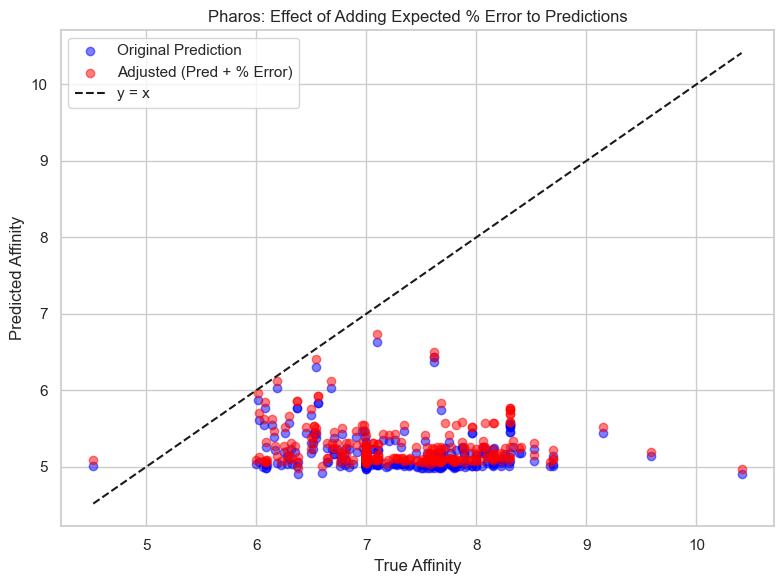

In [58]:
import matplotlib.pyplot as plt

# Step 1: Adjust predictions upward by expected percent error
pharos_df["Adjusted_Prediction"] = pharos_df["Predicted_Value"] * (1 + pharos_df["Expected_Error"] / 100)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Make sure columns exist
true = pharos_df["True_Label"]
pred = pharos_df["Predicted_Value"]
adjusted = pharos_df["Adjusted_Prediction"]

# Compute metrics
rmse_original = np.sqrt(mean_squared_error(true, pred))
mae_original = mean_absolute_error(true, pred)

rmse_adjusted = np.sqrt(mean_squared_error(true, adjusted))
mae_adjusted = mean_absolute_error(true, adjusted)

# Print
print(f"🔵 Original Predictions:")
print(f"   RMSE = {rmse_original:.3f}")
print(f"   MAE  = {mae_original:.3f}")

print(f"\n🔴 Adjusted Predictions (+Expected % Error):")
print(f"   RMSE = {rmse_adjusted:.3f}")
print(f"   MAE  = {mae_adjusted:.3f}")

# Step 2: Plot original and adjusted predictions
plt.figure(figsize=(8, 6))

# Original points
plt.scatter(
    pharos_df["True_Label"],
    pharos_df["Predicted_Value"],
    color="blue",
    alpha=0.5,
    label="Original Prediction"
)

# Adjusted points
plt.scatter(
    pharos_df["True_Label"],
    pharos_df["Adjusted_Prediction"],
    color="red",
    alpha=0.5,
    label="Adjusted (Pred + % Error)"
)

# y = x line
min_val = min(pharos_df["True_Label"].min(), pharos_df["Adjusted_Prediction"].min())
max_val = max(pharos_df["True_Label"].max(), pharos_df["Adjusted_Prediction"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label="y = x")

# Labels
plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("Pharos: Effect of Adding Expected % Error to Predictions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
import statsmodels.api as sm

X = df_clean["Drug_Similarity"].values
y = df_clean["Percent_Error"].values

# Quadratic design matrix
X_poly = sm.add_constant(np.column_stack([X, X**2]))
model = sm.QuantReg(y, X_poly).fit(q=0.50)

# Define a function for prediction
def predict_expected_error_drug_sim(similarity_array):
    X_query = sm.add_constant(np.column_stack([similarity_array, similarity_array**2]), has_constant='add')
    return model.predict(X_query)


# Map similarity
pharos_df["Drug_Similarity"] = pharos_df["Drug_ID"].map(similarity_cache)
pharos_df = pharos_df.dropna(subset=["Drug_Similarity"])

# Predict expected error
pharos_df["Expected_Error_Drug"] = predict_expected_error_drug_sim(pharos_df["Drug_Similarity"].values)

# Adjust predictions upward
pharos_df["Adjusted_Prediction_Drug"] = pharos_df["Predicted_Value"] * (1 + pharos_df["Expected_Error_Drug"] / 100)

🔵 Original Prediction:  RMSE=2.238, MAE=2.111
🔴 Adjusted Prediction:  RMSE=0.979, MAE=0.805


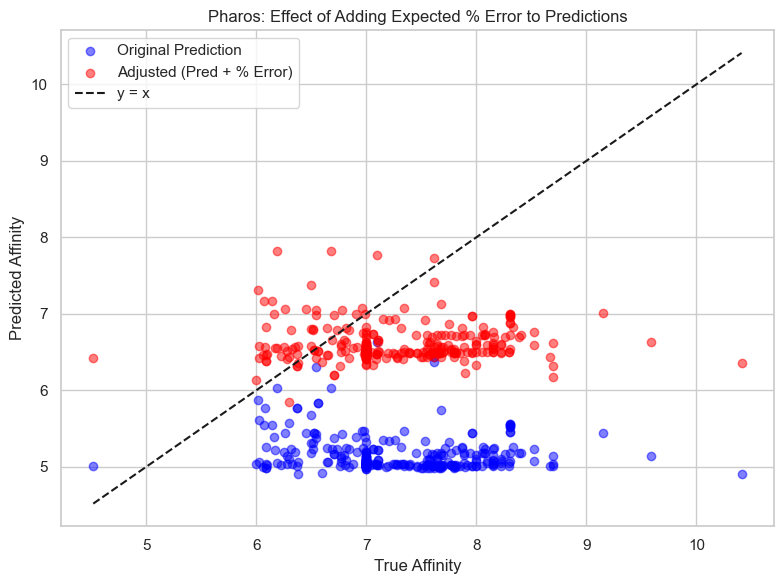

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

true = pharos_df["True_Label"]
original = pharos_df["Predicted_Value"]
adjusted = pharos_df["Adjusted_Prediction_Drug"]

rmse_orig = np.sqrt(mean_squared_error(true, original))
mae_orig = mean_absolute_error(true, original)
rmse_adj = np.sqrt(mean_squared_error(true, adjusted))
mae_adj = mean_absolute_error(true, adjusted)

print(f"🔵 Original Prediction:  RMSE={rmse_orig:.3f}, MAE={mae_orig:.3f}")
print(f"🔴 Adjusted Prediction:  RMSE={rmse_adj:.3f}, MAE={mae_adj:.3f}")
plt.figure(figsize=(8, 6))

# Original points
plt.scatter(
    pharos_df["True_Label"],
    pharos_df["Predicted_Value"],
    color="blue",
    alpha=0.5,
    label="Original Prediction"
)

# Adjusted points
plt.scatter(
    pharos_df["True_Label"],
    pharos_df["Adjusted_Prediction_Drug"],
    color="red",
    alpha=0.5,
    label="Adjusted (Pred + % Error)"
)

# y = x line
min_val = min(pharos_df["True_Label"].min(), pharos_df["Adjusted_Prediction_Drug"].min())
max_val = max(pharos_df["True_Label"].max(), pharos_df["Adjusted_Prediction_Drug"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label="y = x")

# Labels
plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("Pharos: Effect of Adding Expected % Error to Predictions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Index(['Drug_ID', 'Protein_ID', 'True_Label', 'Predicted_Value',
       'Inferred_ERS', 'ERS_Confidence', 'Inferred_CSVS_alt', 'ERS',
       'ERS_rank', 'Inferred_ERS_rank', 'Protein_Similarity', 'Percent_Error',
       'Expected_Error', 'Adjusted_Prediction', 'Drug_Similarity',
       'Expected_Error_Drug', 'Adjusted_Prediction_Drug'],
      dtype='object')
🔵 Original Prediction:  RMSE=2.238, MAE=2.111
🟢 Bin-Adjusted Prediction:  RMSE=0.987, MAE=0.823


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_74061/1894207882.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Affinity_Bin")["Percent_Error"]


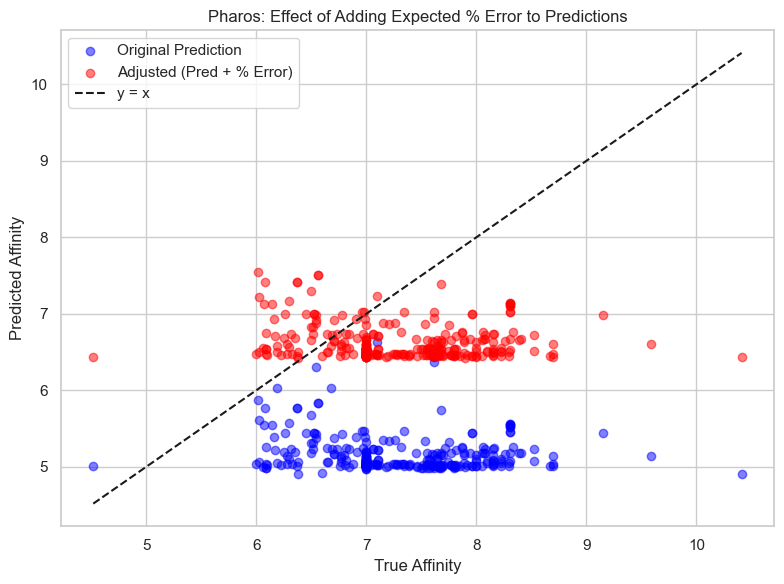

In [61]:

print(pharos_df.columns)
# 1. Define bins
affinity_bins = [4, 5, 6, 7, 8, 9, 10]

pharos_df["Affinity_Bin"] = pd.cut(pharos_df["Predicted_Value"], bins=affinity_bins)

# 2. Compute mean signed error per bin on DAVIS
bin_means = (
    df_clean
    .assign(Affinity_Bin=pd.cut(df_clean["Predicted_Value"], bins=affinity_bins))
    .groupby("Affinity_Bin")["Percent_Error"]
    .mean()
)

# 3. Apply to Pharos
pharos_df = pharos_df.assign(
    Affinity_Bin=pd.cut(pharos_df["Predicted_Value"], bins=affinity_bins),
    Bin_Correction=pharos_df["Affinity_Bin"].map(bin_means).astype(float)  # Convert to float
)

# 4. Apply multiplicative correction (matches drug similarity approach)
pharos_df["Bin_Adjusted"] = pharos_df["Predicted_Value"] * (1 + pharos_df["Bin_Correction"] / 100)

# 5. (Optional) Evaluate against true labels if available
if "True_Label" in pharos_df:
    true = pharos_df["True_Label"]
    original = pharos_df["Predicted_Value"]
    adjusted = pharos_df["Bin_Adjusted"]
    
    rmse_orig = np.sqrt(mean_squared_error(true, original))
    mae_orig = mean_absolute_error(true, original)
    rmse_adj = np.sqrt(mean_squared_error(true, adjusted))
    mae_adj = mean_absolute_error(true, adjusted)
    
    print(f"🔵 Original Prediction:  RMSE={rmse_orig:.3f}, MAE={mae_orig:.3f}")
    print(f"🟢 Bin-Adjusted Prediction:  RMSE={rmse_adj:.3f}, MAE={mae_adj:.3f}")

plt.figure(figsize=(8, 6))

# Original points
plt.scatter(
    pharos_df["True_Label"],
    pharos_df["Predicted_Value"],
    color="blue",
    alpha=0.5,
    label="Original Prediction"
)

# Adjusted points
plt.scatter(
    pharos_df["True_Label"],
    pharos_df["Bin_Adjusted"],
    color="red",
    alpha=0.5,
    label="Adjusted (Pred + % Error)"
)

# y = x line
min_val = min(pharos_df["True_Label"].min(), pharos_df["Bin_Adjusted"].min())
max_val = max(pharos_df["True_Label"].max(), pharos_df["Bin_Adjusted"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label="y = x")

# Labels
plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("Pharos: Effect of Adding Expected % Error to Predictions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()